# Imports

In [89]:
import pandas as pd
import numpy as np
from Bio import SeqIO
import io
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.figure import Figure
import vcf
import matplotlib.lines as mlines
from tqdm.notebook import tqdm
import collections
from collections import Counter
import seaborn as sns

# SNP-Sites

### snp-sites -v -c -o V_snps.vcf V_Mutations_New.fasta
### snp-sites -v -c -o S_snps.vcf S_Mutations_New.fasta
### snp-sites -v -c -o O_snps.vcf O_Mutations_New.fasta
### snp-sites -v -c -o L_snps.vcf L_Mutations_New.fasta
### snp-sites -v -c -o G_snps.vcf G_Mutations_New.fasta
### snp-sites -v -c -o GH_snps.vcf GH_Mutations_New.fasta
### snp-sites -v -c -o GR_snps.vcf GR_Mutations_New.fasta


Run the second line and type in the full path of where the Clade Analysis folder and its contents are located on your local machine when prompted to do so.  

Example Input (will be different on your local machine): /Users/davidchen/Documents/COVID-19_Mutation_signature/Clade_Analysis

In [2]:
directory = input("Print the full file path of your local directory to the Clade Analysis Folder: ")

Print the full file path of your local directory to the Clade Analysis Folder: /Users/davidchen/Documents/GitHub/Mutation_Signature/Clade_Analysis


# Settings

In [3]:
#pd.set_option('display.max_columns', None)  
#pd.set_option('display.max_rows', None)  
#pd.set_option('display.max_colwidth', 500)
plt.style.use('seaborn-white')

In [4]:
protein_loci = pd.read_csv("SARS_proteins_loci.txt", sep="\t")
protein_loci

#chrom  chromStart  chromEnd               name  score strand  \
0   NC_045512v2         265       805               nsp1   1000      +   
1   NC_045512v2         265     21552              pp1ab   1000      +   
2   NC_045512v2         265     13480               pp1a   1000      +   
3   NC_045512v2         805      2719               nsp2   1000      +   
4   NC_045512v2        2719      8554               nsp3   1000      +   
5   NC_045512v2        8554     10054               nsp4   1000      +   
6   NC_045512v2       10054     10972            3CL-PRO   1000      +   
7   NC_045512v2       10972     11842               nsp6   1000      +   
8   NC_045512v2       11842     12091               nsp7   1000      +   
9   NC_045512v2       11842     12091               nsp7   1000      +   
10  NC_045512v2       12091     12685               nsp8   1000      +   
11  NC_045512v2       12091     12685               nsp8   1000      +   
12  NC_045512v2       12685     13024               nsp9   1000      +   
13  NC_045512v2       13024     13441              nsp10   1000      +   
14  NC_045512v2       13441     16236                Pol   1000      +   
15  NC_045512v2       13441     13480              nsp11   1000      +   
16  NC_045512v2       16236     18039                Hel   1000      +   
17  NC_045512v2       18039     19620               ExoN   1000      +   
18  NC_045512v2       19620     20658              nsp15   1000      +   
19  NC_045512v2       20658     21552              nsp16   1000      +   
20  NC_045512v2       21598     25381     S glycoprotein   1000      +   
21  NC_045512v2       21598     23617   Spike protein S1   1000      +   
22  NC_045512v2       23617     25381   Spike protein S2   1000      +   
23  NC_045512v2       24007     25381  Spike protein S2'   1000      +   
24  NC_045512v2       25392     26217              ORF3a   1000      +   
25  NC_045512v2       26244     26469          E protein   1000      +   
26  NC_045512v2       26522     27188          M protein   1000      +   
27  NC_045512v2       27201     27384                ns6   1000      +   
28  NC_045512v2       27438     27756              ORF7a   1000      +   
29  NC_045512v2       27755     27884               ns7b   1000      +   
30  NC_045512v2       27938     28256                ns8   1000      +   
31  NC_045512v2       28273     29530                 NC   1000      +   
32  NC_045512v2       28283     28574              ORF9b   1000      +   
33  NC_045512v2       28733     28952              ORF14   1000      +   

    thickStart  thickEnd   reserved  blockCount  ... geneType  \
0          265       805  12,12,120           1  ...      NaN   
1          265     21552  12,12,120           2  ...      NaN   
2          265     13480  12,12,120           1  ...      NaN   
3          805      2719  12,12,120           1  ...      NaN   
4         2719      8554  12,12,120           1  ...      NaN   
5         8554     10054  12,12,120           1  ...      NaN   
6        10054     10972  12,12,120           1  ...      NaN   
7        10972     11842  12,12,120           1  ...      NaN   
8        11842     12091  12,12,120           1  ...      NaN   
9        11842     12091  12,12,120           1  ...      NaN   
10       12091     12685  12,12,120           1  ...      NaN   
11       12091     12685  12,12,120           1  ...      NaN   
12       12685     13024  12,12,120           1  ...      NaN   
13       13024     13441  12,12,120           1  ...      NaN   
14       13441     16236  12,12,120           2  ...      NaN   
15       13441     13480  12,12,120           1  ...      NaN   
16       16236     18039  12,12,120           1  ...      NaN   
17       18039     19620  12,12,120           1  ...      NaN   
18       19620     20658  12,12,120           1  ...      NaN   
19       20658     21552  12,12,120           1  ...      NaN   
20       21598     25381  12,12,120           1  ... 

# NC_045512 Genome Annotation

In [5]:
url = 'https://raw.githubusercontent.com/davidchen0420/Mutation_Signature/main/GCF_009858895.2_ASM985889v3_genomic.gff'
GFF3 = pd.read_csv(
    filepath_or_buffer=url, 
    sep='\t', 
    header=None,
    names=['seqid', 'source', 'type', 'start', 'end', 'score', 'strand', 'phase', 'attributes'],
    skiprows=[i for i in range(25)])

GFF = GFF3[GFF3['source'].notnull()]
GFF_sorted = GFF.sort_values(by ='start')


In [6]:
#Remove stem loop
GFF_sorted = GFF_sorted[GFF_sorted['type'] != "stem_loop"]
#Remove duplicates 
GFF_sorted = GFF_sorted.drop_duplicates(subset='start', keep="first")
#Reset index
GFF_sorted.reset_index(inplace=True, drop=True)
#Genomic elements from annotation
product_list = ["ORF1a","nsp2", "nsp3", "nps4", "nps5", "nps6", "nps7", "nps8", 
                "nps9", "nps10", "nps11", "3'to 5' exonuclease", "EndoRNAse", 
                "2'-O ribose methyltransferase", "Spike Glycoprotein", "ORF3a",
                "E", "M", "ORF6", "ORF7a", "ORF7b", "ORF8", "N", "ORF10", "3' UTR"]
#Add known genomic elements to dataframe
GFF_sorted['element'] = product_list

Elements of the Reference Genome Annotation

In [7]:
#Take a look at the genomic elements in the reference COVID-19 sequence
GFF_sorted

seqid  source                          type    start      end score  \
0   NC_045512.2  RefSeq                           CDS    266.0  13483.0     .   
1   NC_045512.2  RefSeq  mature_protein_region_of_CDS    806.0   2719.0     .   
2   NC_045512.2  RefSeq  mature_protein_region_of_CDS   2720.0   8554.0     .   
3   NC_045512.2  RefSeq  mature_protein_region_of_CDS   8555.0  10054.0     .   
4   NC_045512.2  RefSeq  mature_protein_region_of_CDS  10055.0  10972.0     .   
5   NC_045512.2  RefSeq  mature_protein_region_of_CDS  10973.0  11842.0     .   
6   NC_045512.2  RefSeq  mature_protein_region_of_CDS  11843.0  12091.0     .   
7   NC_045512.2  RefSeq  mature_protein_region_of_CDS  12092.0  12685.0     .   
8   NC_045512.2  RefSeq  mature_protein_region_of_CDS  12686.0  13024.0     .   
9   NC_045512.2  RefSeq  mature_protein_region_of_CDS  13025.0  13441.0     .   
10  NC_045512.2  RefSeq  mature_protein_region_of_CDS  13442.0  13480.0     .   
11  NC_045512.2  RefSeq  mature_protein_region_of_CDS  18040.0  19620.0     .   
12  NC_045512.2  RefSeq  mature_protein_region_of_CDS  19621.0  20658.0     .   
13  NC_045512.2  RefSeq  mature_protein_region_of_CDS  20659.0  21552.0     .   
14  NC_045512.2  RefSeq                          gene  21563.0  25384.0     .   
15  NC_045512.2  RefSeq                           CDS  25393.0  26220.0     .   
16  NC_045512.2  RefSeq                          gene  26245.0  26472.0     .   
17  NC_045512.2  RefSeq                          gene  26523.0  27191.0     .   
18  NC_045512.2  RefSeq                          gene  27202.0  27387.0     .   
19  NC_045512.2  RefSeq                          gene  27394.0  27759.0     .   
20  NC_045512.2  RefSeq                           CDS  27756.0  27887.0     .   
21  NC_045512.2  RefSeq                          gene  27894.0  28259.0     .   
22  NC_045512.2  RefSeq                          gene  28274.0  29533.0     .   
23  NC_045512.2  RefSeq                          gene  29558.0  29674.0     .   
24  NC_045512.2  RefSeq               three_prime_UTR  29675.0  29903.0     .   

   strand phase                                         attributes  \
0       +     0  ID=cds-YP_009725295.1;Parent=gene-GU280_gp01;D...   
1       +     .  ID=id-YP_009725295.1:181..818;Note=produced by...   
2       +     .  ID=id-YP_009725295.1:819..2763;Note=former nsp...   
3       +     .  ID=id-YP_009725295.1:2764..3263;Note=nsp4B_TM%...   
4       +     .  ID=id-YP_009725295.1:3264..3569;Note=nsp5A_3CL...   
5       +     .  ID=id-YP_009725295.1:3570..3859;Note=nsp6_TM%3...   
6       +     .  ID=id-YP_009725295.1:3860..3942;Note=produced ...   
7       +     .  ID=id-YP_009725295.1:3943..4140;Note=produced ...   
8       +     .  ID=id-YP_009725295.1:4141..4253;Note=ssRNA-bin...   
9       +     .  ID=id-YP_009725295.1:4254..4392;Note=nsp10_Cys...   
10      +     .  ID=id-YP_009725295.1:4393..4405;Note=produced ...   
11      +     .  ID=id-YP_009724389.1:5926..6452;Note=nsp14A2_E...   
12      +     .  ID=id-YP_009724389.1:6453..6798;Note=nsp15-A1 ...   
13      +     .  ID=id-YP_009724389.1:6799..7096;Note=nsp16_OMT...   
14      +     .  ID=gene-GU280_gp02;Dbxref=GeneID:43740568;Name...   
15      +     0  ID=cds-YP_009724391.1;Parent=gene-GU280_gp03;D...   
16      +     .  ID=gene-GU280_gp04;Dbxref=GeneID:43740570;Name...   
17      +     .  ID=gene-GU280_gp05;Dbxref=GeneID:43740571;Name...   
18      +     .  ID=gene-GU280_gp06;Dbxref=GeneID:43740572;Name...   
19      +     .  ID=gene-GU280_gp07;Dbxref=GeneID:43740573;Name...   
20      +     0  ID=cds-YP_009725318.1;Parent=gene-GU280_gp08;D...   
21      +     .  ID=gene-GU280_gp09;Dbxref=GeneID:43740577;Name...   
22      +     .  ID=gene-GU280_gp10;Dbxref=GeneID:43740575;Name...   
23      +     .  ID=gene-GU280_gp11;Dbxref=GeneID:43740576;Name...   
24      +     .         ID=id-NC_045512.2:29675..29903;gbkey=3'UTR   

                          element  
0                           ORF1a  
1         

# Read a VCF as a Pandas dataframe

In [8]:
def read_vcf(clade):
    with open(directory + "/" + str(clade) + "_snps.vcf", 'r') as f:
        lines = [l for l in f if not l.startswith('##')]
    return pd.read_csv(
        io.StringIO(''.join(lines)),
        dtype={'#CHROM': str, 'POS': int, 'ID': str, 'REF': str, 'ALT': str,
               'QUAL': str, 'FILTER': str, 'INFO': str},
        sep='\t'
    ).rename(columns={'#CHROM': 'CHROM'})

Example: Read in first 5 sequences of the Clade V variants VCF file.

Not recommended to load and view the entire vcf file at once using the current implementation of the read_vcf function. May lead to memory overusage. Test to see if your machine can handle loading the entire dataframe. If very slow to laod, try changing the head parameter to show only the first n lines.

In [9]:
clade_V = read_vcf(clade="V")
clade_V

CHROM    POS ID REF ALT QUAL FILTER INFO FORMAT  MN996528.1  ...  \
0        1    662  .   G   A    .      .    .     GT           0  ...   
1        1    673  .   C   T    .      .    .     GT           0  ...   
2        1    683  .   C   T    .      .    .     GT           0  ...   
3        1    700  .   A   G    .      .    .     GT           0  ...   
4        1    703  .   C   T    .      .    .     GT           0  ...   
...    ...    ... ..  ..  ..  ...    ...  ...    ...         ...  ...   
1098     1  29311  .   C   T    .      .    .     GT           0  ...   
1099     1  29315  .   G   T    .      .    .     GT           0  ...   
1100     1  29320  .   A   C    .      .    .     GT           0  ...   
1101     1  29321  .   G   T    .      .    .     GT           0  ...   
1102     1  29348  .   G   T    .      .    .     GT           0  ...   

      hCoV-19/England/PORT-2D1F09/2020|EPI_ISL_499295|2020-04-06  \
0                                                     0            
1                                                     0            
2                                                     0            
3                                                     0            
4                                                     0            
...                                                 ...            
1098                                                  0            
1099                                                  0            
1100                                                  0            
1101                                                  0            
1102                                                  0            

      hCoV-19/Portugal/PT0705/2020|EPI_ISL_510964|2020-03-21  \
0                                                     0        
1                                                     0        
2                                                     0        
3                                                     0        
4                                                     0        
...                                                 ...        
1098                                                  0        
1099                                                  0        
1100                                                  0        
1101                                                  0        
1102                                                  0        

      hCoV-19/Portugal/PT0706/2020|EPI_ISL_510965|2020-03-21  \
0                                                     0        
1                                                     0        
2                                                     0        
3                                                     0        
4                                                     0        
...                                                 ...        
1098                                                  0        
1099                                                  0        
1100                                                  0        
1101                                                  0        
1102                                                  0        

      hCoV-19/USA/MN-MDH-1497/2020|EPI_ISL_518890|2020-03-20  \
0                                                     0        
1                                                     0        
2                                                     0        
3                                                     0        
4                                                     0        
...                                                 ...        
1098                                                  0        
1099                                                  0        
1100                                                  0        
1101                                                  0        
1102                                                  0        

    

In [10]:
clade_V.head(5)

CHROM  POS ID REF ALT QUAL FILTER INFO FORMAT  MN996528.1  ...  \
0     1  662  .   G   A    .      .    .     GT           0  ...   
1     1  673  .   C   T    .      .    .     GT           0  ...   
2     1  683  .   C   T    .      .    .     GT           0  ...   
3     1  700  .   A   G    .      .    .     GT           0  ...   
4     1  703  .   C   T    .      .    .     GT           0  ...   

   hCoV-19/England/PORT-2D1F09/2020|EPI_ISL_499295|2020-04-06  \
0                                                  0            
1                                                  0            
2                                                  0            
3                                                  0            
4                                                  0            

   hCoV-19/Portugal/PT0705/2020|EPI_ISL_510964|2020-03-21  \
0                                                  0        
1                                                  0        
2                                                  0        
3                                                  0        
4                                                  0        

   hCoV-19/Portugal/PT0706/2020|EPI_ISL_510965|2020-03-21  \
0                                                  0        
1                                                  0        
2                                                  0        
3                                                  0        
4                                                  0        

   hCoV-19/USA/MN-MDH-1497/2020|EPI_ISL_518890|2020-03-20  \
0                                                  0        
1                                                  0        
2                                                  0        
3                                                  0        
4                                                  0        

   hCoV-19/Switzerland/BS-UHB-42199741/2020|EPI_ISL_528247|2020-03-20  \
0                                                  0                    
1                                                  0                    
2                                                  0                    
3                                                  0                    
4                                                  0                    

   hCoV-19/USA/MI-QDX-274/2020|EPI_ISL_571036|2020-03-17  \
0                                                  0       
1                                                  0       
2                                                  0       
3                                                  0       
4                                                  0       

   hCoV-19/Switzerland/VD-ETHZ-100186/2020|EPI_ISL_574990|2020-03-16  \
0                                                  0                   
1                                                  0                   
2                                                  0                   
3                                                  0                   
4                                                  0                   

   hCoV-19/USA/CA-QDX-1644/2020|EPI_ISL_603912|2020-03-19  \
0                                                  0        
1                                                  0        
2                                                  0        
3                                                  0        
4                                                  0        

   hCoV-19/USA/CA-QDX-1669/2020|EPI_ISL_603920|2020-03-18  \
0                                                  0        
1                                                  0        
2                                                  0        
3                                                  0        
4                                                  0        

   hCoV-19/Argentina/PAIS-A0171/2020|EPI_ISL_792260|2020-05-19  
0                                                  0            
1   

In [9]:
def filter_vcf(clade, aaf_limit):

    vcf_reader = vcf.Reader(open(directory + "/" + str(clade) + "_snps.vcf", 'r'))
    
    total = []
    position = []
    ref = []
    alt = []
    
    for record in vcf_reader:
        total.append(record.POS)
        if aaf_limit > 0:
            if record.aaf[0] > aaf_limit:
                position.append(record.POS)
                ref.append(record.REF)
                alt.append(record.ALT)
            else:
                pass
        else:
            position.append(record.POS)
            ref.append(record.REF)
            alt.append(record.ALT)
    
    if aaf_limit > 0:
        print()
        data = pd.DataFrame(columns=["position", "reference", "alternate"])
        data["position"] = position
        data["reference"] = ref
        data["alternate"] = alt
    else:
        data = pd.DataFrame(columns=["position", "reference", "alternate"])
        data["position"] = position
        data["reference"] = ref
        data["alternate"] = alt
        
    return data

Example: Read in all variants associated with Clade O sequences and with an alternate allele frequency of 0.5%

In [90]:
clade_V_filtered = filter_vcf(clade="V", aaf_limit=0.005)
clade_V_filtered

position reference alternate
0        988         C       [T]
1       1148         G       [T]
2       1314         C       [T]
3       1368         T       [C]
4       1457         C       [T]
5       1587         A       [G]
6       1820         G       [A]
7       2091         C       [T]
8       4185         G       [A]
9       4236         A       [G]
10      6027         C       [T]
11      8078         C       [T]
12      9170         C       [T]
13     10236         A       [G]
14     10323         A       [G]
15     11083         G       [T]
16     12781         C       [T]
17     17944         G       [T]
18     18086         C       [T]
19     25572         C       [T]
20     26144         G       [T]
21     26885         C       [T]

# SBS-192 Classification Scheme Population Mutation Signature Plot

In [10]:
def explode(df, lst_cols, fill_value='', preserve_index=False):
    # make sure `lst_cols` is list-alike
    if (lst_cols is not None
        and len(lst_cols) > 0
        and not isinstance(lst_cols, (list, tuple, np.ndarray, pd.Series))):
        lst_cols = [lst_cols]
    # all columns except `lst_cols`
    idx_cols = df.columns.difference(lst_cols)
    # calculate lengths of lists
    lens = df[lst_cols[0]].str.len()
    # preserve original index values    
    idx = np.repeat(df.index.values, lens)
    # create "exploded" DF
    res = (pd.DataFrame({
                col:np.repeat(df[col].values, lens)
                for col in idx_cols},
                index=idx)
             .assign(**{col:np.concatenate(df.loc[lens>0, col].values)
                            for col in lst_cols}))
    # append those rows that have empty lists
    if (lens == 0).any():
        # at least one list in cells is empty
        res = (res.append(df.loc[lens==0, idx_cols], sort=False)
                  .fillna(fill_value))
    # revert the original index order
    res = res.sort_index()
    # reset index if requested
    if not preserve_index:        
        res = res.reset_index(drop=True)
    return res

In [11]:
def sig_table(clade, base_type, aaf_limit=0):
    
    reference =  str(next(SeqIO.parse(directory + "/MN996528_1.fasta", "fasta")).seq).upper()
    vcf_reader = vcf.Reader(open(directory + "/" + str(clade) + "_snps.vcf", 'r'))
  
    total = [] 
    position = []
    ref = []
    alt = []
    
    for record in vcf_reader:
        total.append(record.POS)
        if aaf_limit > 0:
            if record.aaf[0] > aaf_limit:
                position.append(record.POS)
                ref.append(record.REF)
                alt.append(record.ALT)
            else:
                pass
        else:
            position.append(record.POS)
            ref.append(record.REF)
            alt.append(record.ALT)
    
   
    print(str(len(position)) + " alternate SNPs included out of a total of " + str(len(total)) + " SNPs" )
    
    counter = 0
    for i in range(len(ref)):
        if ref[i] == reference[position[i] - 1]:
            pass
        else: 
            counter += 1
    print(str(counter) + ' identified SNPs do not match reference base!')
    
    
    snps = pd.DataFrame(index = range(len(position)), columns=['position', 'reference', 'alternate'])
    snps['position'] = position
    snps['reference'] = ref
    snps['alternate'] = alt
    
    snps_expand = explode(snps, ["alternate"])
    
    sbs_96 = pd.read_excel(directory + "/WGS_PCAWG.96.xlsx")
    classification = sbs_96.iloc[:, :2]
    classification['Frequency'] = 0
    
    if base_type == 'purine':
        for row in range(len(classification)):
            mut_type = classification.loc[row, 'Mutation type']
            if mut_type[0] == "C":
                classification.loc[row, 'Mutation type'] = "G" + str(mut_type[1:])   
            if mut_type[0] == "T":
                classification.loc[row, 'Mutation type'] = "A" + str(mut_type[1:])
            if classification.loc[row, 'Mutation type'][0] == "G" and classification.loc[row, 'Mutation type'][-1] == "G":
                classification.loc[row, 'Mutation type'] = classification.loc[row, 'Mutation type'][:2] + "C"
            if classification.loc[row, 'Mutation type'][0] == "A" and classification.loc[row, 'Mutation type'][-1] == "A":
                classification.loc[row, 'Mutation type'] = classification.loc[row, 'Mutation type'][:2] + "T"


            trinuc = classification.loc[row, 'Trinucleotide']

            if mut_type[0] == "C":
                classification.loc[row, 'Trinucleotide'] = str(trinuc[0]) + "G" + str(trinuc[-1])
            if mut_type[0] == "T":
                classification.loc[row, 'Trinucleotide'] = str(trinuc[0]) + "A" + str(trinuc[-1])

    for i in range(len(snps_expand)):

        #position on ref seq
        position = snps_expand.loc[i, "position"] -1
        #trinuc context on ref seq
        trinuc_context = str(reference[position-1:position+2])

        #SBS classification
        mutation_type = str(snps_expand.loc[i, "reference"]) + ">" + str(snps_expand.loc[i, "alternate"])

        trinuc_filter = classification[classification['Trinucleotide'] == trinuc_context] 
        row_index = trinuc_filter[trinuc_filter['Mutation type'] == mutation_type].index

        classification.loc[row_index, 'Frequency'] += 1

    print(str(classification['Frequency'].sum()) + " total SNPs sorted into SBS-192 classification scheme")

    return classification
    

In [12]:
def sig_plot(clade, base_type, aaf_limit=0):

    classification = sig_table(clade = clade, base_type = base_type, aaf_limit=aaf_limit)
    
    fig = plt.figure(figsize=(20, 6))
    ax = fig.add_subplot(111)

    N = 96
    ind = np.arange(96)   

    color_list = [(0.416, 0.733, 0.918), (0,0,0), (0.765, 0.172, 0.157), (0.785, 0.785, 0.785), (0.678, 0.808, 0.412), (0.878, 0.773, 0.769)]

    p1 = ax.bar(range(0,16), classification.iloc[0:16, 2], bottom=0, color = color_list[0])
    p2 = ax.bar(range(16,32), classification.iloc[16:32, 2], bottom=0, color = color_list[1])
    p3 = ax.bar(range(32,48), classification.iloc[32:48, 2], bottom=0, color = color_list[2])
    p4 = ax.bar(range(48,64), classification.iloc[48:64, 2], bottom=0, color = color_list[3])
    p5 = ax.bar(range(64,80), classification.iloc[64:80, 2], bottom=0, color = color_list[4])
    p6 = ax.bar(range(80,96), classification.iloc[80:96, 2], bottom=0, color = color_list[5])

    y_limit = ax.get_ylim()[1]

    rect1 = patches.Rectangle((0, y_limit + y_limit/50), 15, y_limit/20, color = color_list[0], clip_on=False) 
    rect2 = patches.Rectangle((16, y_limit + y_limit/50), 15, y_limit/20, color = color_list[1], clip_on=False) 
    rect3 = patches.Rectangle((32, y_limit + y_limit/50), 15, y_limit/20, color = color_list[2], clip_on=False) 
    rect4 = patches.Rectangle((48, y_limit + y_limit/50), 15, y_limit/20, color = color_list[3], clip_on=False) 
    rect5 = patches.Rectangle((64, y_limit + y_limit/50), 15, y_limit/20, color = color_list[4], clip_on=False) 
    rect6 = patches.Rectangle((80, y_limit + y_limit/50), 15, y_limit/20, color = color_list[5], clip_on=False) 

    if base_type == 'pyrimidine':
        plt.text(7, y_limit + y_limit/9, "C>A", fontsize=12, weight="bold")
        plt.text(23, y_limit + y_limit/9, "C>G", fontsize=12, weight="bold")
        plt.text(39, y_limit + y_limit/9, "C>T", fontsize=12, weight="bold")
        plt.text(55, y_limit + y_limit/9, "T>A", fontsize=12, weight="bold")
        plt.text(71, y_limit + y_limit/9, "T>C", fontsize=12, weight="bold")
        plt.text(87, y_limit + y_limit/9, "T>G", fontsize=12, weight="bold")
    if base_type == 'purine':
        plt.text(7, y_limit + y_limit/9, "G>A", fontsize=12, weight="bold")
        plt.text(23, y_limit + y_limit/9, "G>C", fontsize=12, weight="bold")
        plt.text(39, y_limit + y_limit/9, "G>T", fontsize=12, weight="bold")
        plt.text(55, y_limit + y_limit/9, "A>T", fontsize=12, weight="bold")
        plt.text(71, y_limit + y_limit/9, "A>C", fontsize=12, weight="bold")
        plt.text(87, y_limit + y_limit/9, "A>G", fontsize=12, weight="bold")

    ax.add_patch(rect1)
    ax.add_patch(rect2)
    ax.add_patch(rect3)
    ax.add_patch(rect4)
    ax.add_patch(rect5)
    ax.add_patch(rect6)

    ax.set_xlabel('SubType', fontsize=15, weight="bold")
    ax.yaxis.set_label_text('Count of Single Base Substitutions', fontsize=15, weight="bold")

    ax.set_xticks(ind)
    ax.set_xticklabels(classification['Trinucleotide'], fontsize=6)

    plt.xticks(rotation=90)
    ax.margins(x=0)
    ax.set_title(" ", pad=140)

    ax.grid(axis = 'y', color=color_list[3], linestyle='-', linewidth = 1)
    ax.set_axisbelow(True)
    ax.xaxis.labelpad= 10
    ax.yaxis.labelpad= 10

Example: Visualize the variant bases in Clade V sequences with an alternate allele frequency of 0.5% and with a purine reference base.

22 alternate SNPs included out of a total of 1103 SNPs
0 identified SNPs do not match reference base!
10 total SNPs sorted into SBS-192 classification scheme


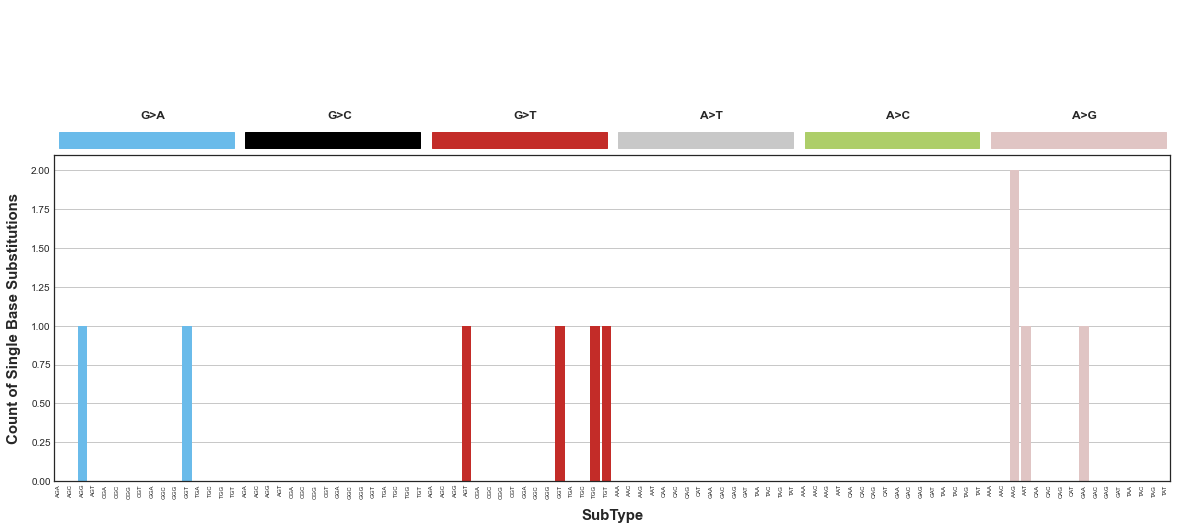

In [16]:
sig_plot(clade="V", base_type="purine", aaf_limit=0.005)

Example: Visualize the variant bases in Clade V sequences with an alternate allele frequency of 0.5% and with a pyrimidine reference base.

22 alternate SNPs included out of a total of 1103 SNPs
0 identified SNPs do not match reference base!
12 total SNPs sorted into SBS-192 classification scheme


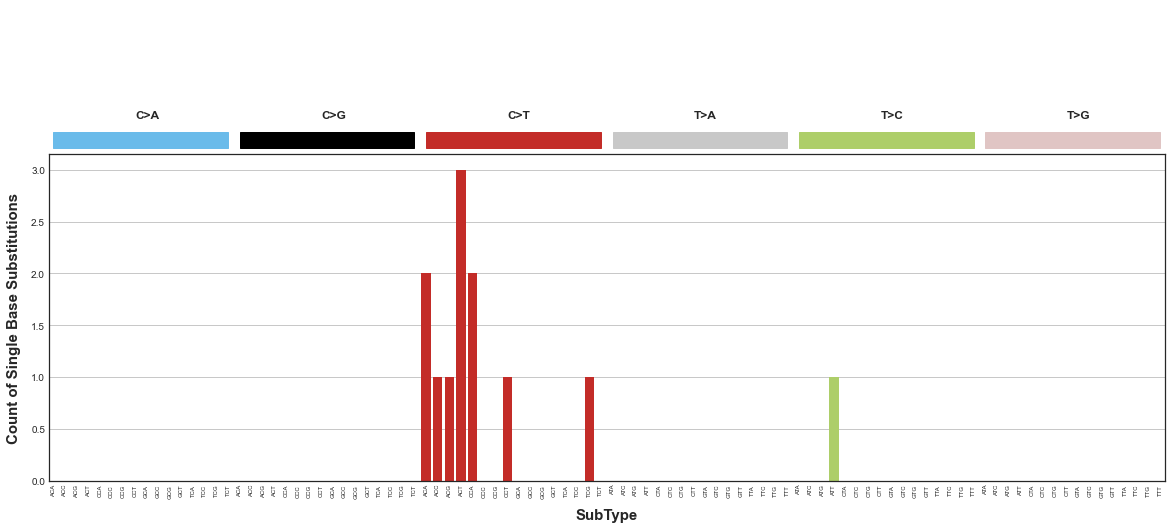

In [17]:
sig_plot(clade="V", base_type="pyrimidine", aaf_limit=0.005)

# Search for all variants in a clade with a substitution at a specific genomic position

In [18]:
def variant_search_position(clade, position):
    data_vcf = read_vcf(clade)
    sample = data_vcf[data_vcf["POS"] == position].loc[:, "MN996528.1":]
    sample = sample.replace(0, np.nan)
    return sample.dropna(how="all", axis=1).columns.tolist()
    

In [19]:
def variant_search_range(clade, start_position, end_position):
    data_vcf = read_vcf(clade)
    search_df = pd.DataFrame(columns = ["position", "reference_id"])
    for i in range(start_position, end_position + 1):
        sample = data_vcf[data_vcf["POS"] == i].loc[:, "MN996528.1":]
        sample = sample.replace(0, np.nan)
        reference_id = sample.dropna(how="all", axis=1).columns.tolist() 
        if len(reference_id)>0:
            search_df = search_df.append(pd.DataFrame({"position": [i], "reference_id": [reference_id]}), ignore_index=True)
        else:
            pass
    return search_df

Example: What sequence from Clade V has a variant at position 1002?

In [20]:
variant_search_position(clade="V", position=1002)

[]

Example: What sequence from Clade V has a variant from position 4000 to 5000? (Note 0 index starts at the first base and end position parameter is inclusive of the end position)

In [21]:
variant_search_range(clade="V", start_position=4000, end_position=5000)

position                                       reference_id
0      4084  [hCoV-19/England/20144075304/2020|EPI_ISL_4660...
1      4093                                [hCoV-19/South.139]
2      4095  [hCoV-19/Scotland/GCVR-170091/2020|EPI_ISL_459...
3      4127                                [hCoV-19/South.139]
4      4158  [hCoV-19/Belgium/Rega-0330251/2020|EPI_ISL_458...
5      4171  [hCoV-19/England/NORW-E9AD2/2020|EPI_ISL_44835...
6      4185  [hCoV-19/England/CAMB-7F39A/2020|EPI_ISL_44297...
7      4195  [hCoV-19/Scotland/EDB2853/2020|EPI_ISL_488965|...
8      4206  [hCoV-19/England/CAMB-7BBF0/2020|EPI_ISL_44218...
9      4207  [hCoV-19/USA/NY-NYUMC31/2020|EPI_ISL_418977|20...
10     4236  [hCoV-19/USA/MI-QDX-1048/2020|EPI_ISL_571724|2...
11     4255  [hCoV-19/USA/NY-NYCPHL-000133/2020|EPI_ISL_631...
12     4273  [hCoV-19/Spain/MD-H12-LP29/2020|EPI_ISL_430719...
13     4274  [hCoV-19/Spain/MD-H12-LP29/2020|EPI_ISL_430719...
14     4300  [hCoV-19/England/NORT-294AC5/2020|EPI_ISL_4885...
15     4320  [hCoV-19/England/LOND-125FFC4/2020|EPI_ISL_516...
16     4327  [hCoV-19/England/NORT-281BE6/2020|EPI_ISL_4887...
17     4330  [hCoV-19/England/BRIS-1247D3/2020|EPI_ISL_4438...
18     4331  [hCoV-19/Singapore/52cul/2020|EPI_ISL_574480|2...
19     4338  [hCoV-19/Poland/PL_P39/2020|EPI_ISL_455452|202...
20     4369  [hCoV-19/England/PORT-2D1103/2020|EPI_ISL_4753...
21     4399  [hCoV-19/Germany/HH-hpi-p1851/2020|EPI_ISL_776...
22     4666  [hCoV-19/England/LOND-D6443/2020|EPI_ISL_48756...
23     4683  [hCoV-19/England/NORT-282AD9/2020|EPI_ISL_4887...
24     4699                   [hCoV-19/New.14, hCoV-19/New.15]
25     4720  [hCoV-19/England/SHEF-C9A23/2020|EPI_ISL_47542...
26     4755  [hCoV-19/England/NORW-E8718/2020|EPI_ISL_44822...
27     4776  [hCoV-19/Spain/MD-IBV-99008610/2020|EPI_ISL_65...
28     4780  [hCoV-19/Belgium/rega-0429619/2020|EPI_ISL_734...
29     4788  [hCoV-19/USA/CA-QDX-1644/2020|EPI_ISL_603912|2...
30     4794  [hCoV-19/England/LOND-124F7B0/2020|EPI_ISL_665...
31     4803  [hCoV-19/USA/NV-NSPHL-A0008/2020|EPI_ISL_51529...
32     4827  [hCoV-19/England/20134060804/2020|EPI_ISL_4231...
33     4832  [hCoV-19/England/OXON-AC561/2020|EPI_ISL_44846...
34     4838  [hCoV-19/England/NOTT-10FA3F/2020|EPI_ISL_4326...
35     4876  [hCoV-19/USA/OR-PROV-103/2020|EPI_ISL_482373|2...
36     4887  [hCoV-19/England/CAMB-7EB84/2020|EPI_ISL_44296...
37     4888  [hCoV-19/USA/NY-AECOM_075/2020|EPI_ISL_826638|...
38     4891  [hCoV-19/Scotland/GCVR-171124/2020|EPI_ISL_459...
39     4897  [hCoV-19/England/20134018402/2020|EPI_ISL_4230...
40     4904  [hCoV-19/England/CAMB-72D6C/2020|EPI_ISL_44012...
41     4907  [hCoV-19/USA/FL-BPHL-0168/2020|EPI_ISL_480819|...
42     4912  [hCoV-19/USA/TX-QDX-834/2020|EPI_ISL_571687|20...
43     4916  [hCoV-19/England/PORT-2D17C5/2020|EPI_ISL_4844...
44     4924  [hCoV-19/England/CAMB-76B31/2020|EPI_ISL_43839...
45     4927  [hCoV-19/Scotland/CVR3075/2020|EPI_ISL_461659|...
46     4959  [hCoV-19/England/20166072004/2020|EPI_ISL_4665...
47     4965  [hCoV-19/England/LIVE-A8FC1/2020|EPI_ISL_51724...
48     4993  [hCoV-19/Australia/WA107/2020|EPI_ISL_512760|2...

# Search for all variants in a clade with a specific reference to alternate base substitution 

In [22]:
def variant_search_base(clade, ref_base, alt_base):
    data_vcf = read_vcf(clade)
    sample = data_vcf[data_vcf["REF"] == ref_base]
    sample = data_vcf[data_vcf["ALT"] == alt_base].loc[:, "MN996528.1":]
    sample = sample.replace(0, np.nan)
    return sample.dropna(how="all", axis=1).columns.tolist()

Example: What sequence from Clade V has a reference base of G and alternate base of A?

In [23]:
variant_search_base(clade="V", ref_base="G", alt_base="A")

['hCoV-19/Finland/14M20/2020|EPI_ISL_418405|2020-03-14',
 'hCoV-19/Australia/VIC25/2020|EPI_ISL_419744|2020-03-10',
 'hCoV-19/Australia/VIC82/2020|EPI_ISL_419794|2020-03-14',
 'hCoV-19/England/20139063604/2020|EPI_ISL_420746|2020-03-25',
 'hCoV-19/England/20139063704/2020|EPI_ISL_420747|2020-03-28',
 'hCoV-19/England/20139063804/2020|EPI_ISL_420748|2020-03-28',
 'hCoV-19/England/20132091804/2020|EPI_ISL_423824|2020-03-22',
 'hCoV-19/Austria/CeMM0232/2020|EPI_ISL_438064|2020-03-18',
 'hCoV-19/England/CAMB-77286/2020|EPI_ISL_439385|2020-03-30',
 'hCoV-19/England/CAMB-73E1D/2020|EPI_ISL_440330|2020-03-18',
 'hCoV-19/England/CAMB-7C4A9/2020|EPI_ISL_441656|2020-04-05',
 'hCoV-19/England/CAMB-7F39A/2020|EPI_ISL_442973|2020-04-08',
 'hCoV-19/England/CAMB-1AA562/2020|EPI_ISL_443457|2020-04-17',
 'hCoV-19/England/CAMB-842D1/2020|EPI_ISL_443460|2020-04-16',
 'hCoV-19/England/CAMB-822E2/2020|EPI_ISL_443481|2020-04-14',
 'hCoV-19/England/CAMB-83472/2020|EPI_ISL_443488|2020-04-15',
 'hCoV-19/Englan

# Search for top n variants with the highest mutation burden

In [24]:
def variant_search_top_n(clade, top_n):
    data_vcf = read_vcf(clade)
    return data_vcf.loc[:, "MN996528.1":].sum(axis=0).nlargest(top_n)

Example: Return the top n sequences from Clade V with the highest total variant burden

In [25]:
variant_search_top_n(clade="V", top_n=10)

hCoV-19/Germany/SL-SU-10427348/2020|EPI_ISL_707948|2020-03-14    11
hCoV-19/Scotland/CVR3677/2020|EPI_ISL_478091|2020-05-22           7
hCoV-19/Argentina/PAIS-B0003/2020|EPI_ISL_792399|2020-05-30       7
hCoV-19/Scotland/CVR3378/2020|EPI_ISL_456807|2020-05-06           7
hCoV-19/USA/CT-UW-3845/2020|EPI_ISL_427161|2020-03-25             7
hCoV-19/Spain/AR-ISCIII-201778/2020|EPI_ISL_578192|2020-03-08     7
hCoV-19/England/BRIS-13308B/2020|EPI_ISL_511955|2020-06-25        7
hCoV-19/England/NORT-281612/2020|EPI_ISL_488792|2020-03-17        7
hCoV-19/England/BRIS-123F45/2020|EPI_ISL_492810|2020-04-08        7
hCoV-19/England/PORT-2D0DB5/2020|EPI_ISL_475284|2020-03-30        7
dtype: int64

# Clade Aggregate Rainfall Plot Visualization with Reference Genome Annotation Map

In [44]:
def rainfall_plot_population(clade, aaf_limit):

    reference_dict = {"A": "o","C": "x", "G": "D" , "T":"^" }
    alternate_dict = {"A": "firebrick","C": "indigo", "G": "forestgreen" , "T":"royalblue"}
    
    filtered_df = filter_vcf(clade, aaf_limit = aaf_limit)

    filtered_distance = [1]
    for i in range(1, len(filtered_df)):
        filtered_distance.append(filtered_df.iloc[i,0] - filtered_df.iloc[i-1,0])
        
    fig, ax = plt.subplots(figsize=(20, 10))
    for mut in range(len(filtered_df)):
        marker = reference_dict[filtered_df.loc[mut, 'reference']]
        color = alternate_dict[str(filtered_df.loc[mut, 'alternate'][0])]
        ax.scatter(filtered_df.loc[mut,"position"], filtered_distance[mut], c=color, marker=marker, s=100)

    ax.set_yscale("log")
    ax.set_xlim([0, 30000])
    ax.set_ylim([1, 10000])
    ax.set_title("Rainfall Plot", pad=100, size=20)
    ax.set_xlabel("Genomic Position", labelpad=10, size=20)
    ax.set_ylabel("Genomic Distance", labelpad=10, size=20)
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.tick_params(axis='both', which='minor', labelsize=15)

    A_C = mlines.Line2D([], [], color='indigo', marker='o', linestyle='None',
                              markersize=10, label='A>C')
    A_G = mlines.Line2D([], [], color='forestgreen', marker='o', linestyle='None',
                              markersize=10, label='A>G')
    A_T = mlines.Line2D([], [], color='royalblue', marker='o', linestyle='None',
                              markersize=10, label='A>T')

    C_A = mlines.Line2D([], [], color='firebrick', marker='x', linestyle='None',
                              markersize=10, label='C>A')
    C_G = mlines.Line2D([], [], color='forestgreen', marker='x', linestyle='None',
                              markersize=10, label='C>G')
    C_T = mlines.Line2D([], [], color='royalblue', marker='x', linestyle='None',
                              markersize=10, label='C>T')

    G_A = mlines.Line2D([], [], color='firebrick', marker='D', linestyle='None',
                              markersize=10, label='G>A')
    G_C = mlines.Line2D([], [], color='indigo', marker='D', linestyle='None',
                              markersize=10, label='G>C')
    G_T = mlines.Line2D([], [], color='royalblue', marker='D', linestyle='None',
                              markersize=10, label='G>T')

    T_A = mlines.Line2D([], [], color='firebrick', marker='^', linestyle='None',
                              markersize=10, label='T>A')
    T_C = mlines.Line2D([], [], color='indigo', marker='^', linestyle='None',
                              markersize=10, label='T>C')
    T_G = mlines.Line2D([], [], color='forestgreen', marker='^', linestyle='None',
                              markersize=10, label='T>G')
    fig.patch.set_facecolor('white')

    ax.text(400, 20000, "nsp1", horizontalalignment='center', verticalalignment='center', rotation=90, size=12)
    ax.add_patch(patches.Rectangle((1, 10000),805,2000,linewidth=1,edgecolor='black',facecolor='black', label="nsp1", clip_on=False))
    ax.text(1762, 20000, "nsp2", horizontalalignment='center', verticalalignment='center', rotation=90, size=12)
    ax.add_patch(patches.Rectangle((806, 10000),1913,2000,linewidth=1,edgecolor='black',facecolor='none', label="nsp2", clip_on=False))
    ax.text(5600, 20000, "nsp3", horizontalalignment='center', verticalalignment='center', rotation=90, size=12)
    ax.add_patch(patches.Rectangle((2720, 10000),5834,2000,linewidth=1,edgecolor='black',facecolor='black', label="nsp3", clip_on=False))

    ax.text(9300, 20000, "nsp4", horizontalalignment='center', verticalalignment='center', rotation=90, size=12)
    ax.add_patch(patches.Rectangle((8555, 10000),1499,2000,linewidth=1,edgecolor='black',facecolor='none', label="nsp4", clip_on=False))
    ax.text(10500, 20000, "nsp5", horizontalalignment='center', verticalalignment='center', rotation=90, size=12)
    ax.add_patch(patches.Rectangle((10055, 10000),917,2000,linewidth=1,edgecolor='black',facecolor='black', label="nsp5", clip_on=False))
    ax.text(11400, 20000, "nsp6", horizontalalignment='center', verticalalignment='center', rotation=90, size=12)
    ax.add_patch(patches.Rectangle((10973, 10000),869,2000,linewidth=1,edgecolor='black',facecolor='none', label="nsp6", clip_on=False))
    ax.text(12000, 20000, "nsp7", horizontalalignment='center', verticalalignment='center', rotation=90, size=12)
    ax.add_patch(patches.Rectangle((11843, 10000),248,2000,linewidth=1,edgecolor='black',facecolor='black', label="nsp7", clip_on=False))
    ax.text(12400, 20000, "nsp8", horizontalalignment='center', verticalalignment='center', rotation=90, size=12)
    ax.add_patch(patches.Rectangle((12092, 10000),593,2000,linewidth=1,edgecolor='black',facecolor='none', label="nsp8", clip_on=False))
    ax.text(12850, 20000, "nsp9", horizontalalignment='center', verticalalignment='center', rotation=90, size=12)
    ax.add_patch(patches.Rectangle((12686, 10000),338,2000,linewidth=1,edgecolor='black',facecolor='black', label="nsp9", clip_on=False))
    ax.text(13250, 20000, "nsp10", horizontalalignment='center', verticalalignment='center', rotation=90, size=12)
    ax.add_patch(patches.Rectangle((13025, 10000),416,2000,linewidth=1,edgecolor='black',facecolor='none', label="nsp10", clip_on=False))
    ax.text(13550, 20000, "nsp11", horizontalalignment='center', verticalalignment='center', rotation=90, size=12)
    ax.add_patch(patches.Rectangle((13442, 10000),38,2000,linewidth=1,edgecolor='black',facecolor='black', label="nsp11", clip_on=False))

    ax.text(15000, 20000, "nsp12", horizontalalignment='center', verticalalignment='center', rotation=90, size=12)
    ax.add_patch(patches.Rectangle((13480, 10000),2768,2000,linewidth=1,edgecolor='black',facecolor='none', label="nsp12", clip_on=False))
    ax.text(17100, 20000, "nsp13", horizontalalignment='center', verticalalignment='center', rotation=90, size=12)
    ax.add_patch(patches.Rectangle((16237, 10000),1802,2000,linewidth=1,edgecolor='black',facecolor='black', label="nsp13", clip_on=False))
    ax.text(18800, 20000, "nsp14", horizontalalignment='center', verticalalignment='center', rotation=90, size=12)
    ax.add_patch(patches.Rectangle((18040, 10000),1580,2000,linewidth=1,edgecolor='black',facecolor='none', label="nsp14", clip_on=False))
    ax.text(20100, 20000, "nsp15", horizontalalignment='center', verticalalignment='center', rotation=90, size=12)
    ax.add_patch(patches.Rectangle((19621, 10000),1037,2000,linewidth=1,edgecolor='black',facecolor='black', label="nsp15", clip_on=False))
    ax.text(21100, 20000, "nsp16", horizontalalignment='center', verticalalignment='center', rotation=90, size=12)
    ax.add_patch(patches.Rectangle((20659, 10000),893,2000,linewidth=1,edgecolor='black',facecolor='none', label="nsp16", clip_on=False))

    ax.text(23400, 20000, "S", horizontalalignment='center', verticalalignment='center', rotation=90, size=12)
    ax.add_patch(patches.Rectangle((21563, 10000),3821,2000,linewidth=1,edgecolor='black',facecolor='black', label="S", clip_on=False))
    ax.text(25700, 20000, "ORF3a", horizontalalignment='center', verticalalignment='center', rotation=90, size=12)
    ax.add_patch(patches.Rectangle((25393, 10000),827,2000,linewidth=1,edgecolor='black',facecolor='none', label="ORF3a", clip_on=False))
    ax.text(26300, 20000, "E", horizontalalignment='center', verticalalignment='center', rotation=90, size=12)
    ax.add_patch(patches.Rectangle((26245, 10000),227,2000,linewidth=1,edgecolor='black',facecolor='black', label="E", clip_on=False))
    ax.text(26750, 20000, "M",  horizontalalignment='center', verticalalignment='center',rotation=90, size=12)
    ax.add_patch(patches.Rectangle((26523, 10000),668,2000,linewidth=1,edgecolor='black',facecolor='none', label="M", clip_on=False))
    ax.text(27150, 20000, "ORF6",  horizontalalignment='center', verticalalignment='center',rotation=90, size=12)
    ax.add_patch(patches.Rectangle((27202, 10000),185,2000,linewidth=1,edgecolor='black',facecolor='black', label="ORF6", clip_on=False))
    ax.text(27450, 20000, "ORF7a",  horizontalalignment='center', verticalalignment='center',rotation=90, size=12)
    ax.add_patch(patches.Rectangle((27394, 10000),365,2000,linewidth=1,edgecolor='black',facecolor='none', label="ORF7a", clip_on=False))
    ax.text(27750, 20000, "ORF7b",  horizontalalignment='center', verticalalignment='center',rotation=90, size=12)
    ax.add_patch(patches.Rectangle((27756, 10000),131,2000,linewidth=1,edgecolor='black',facecolor='black', label="ORF7b", clip_on=False))
    ax.text(28100, 20000, "ORF8",  horizontalalignment='center', verticalalignment='center',rotation=90, size=12)
    ax.add_patch(patches.Rectangle((27894, 10000),365,2000,linewidth=1,edgecolor='black',facecolor='none', label="ORF8", clip_on=False))
    ax.text(28900, 20000, "N",  horizontalalignment='center', verticalalignment='center',rotation=90, size=12)
    ax.add_patch(patches.Rectangle((28274, 10000),1259,2000,linewidth=1,edgecolor='black',facecolor='black', label="N", clip_on=False))
    ax.text(29400, 20000, "ORF10",  horizontalalignment='center', verticalalignment='center',rotation=90, size=12)
    ax.add_patch(patches.Rectangle((29558, 10000),116,2000,linewidth=1,edgecolor='black',facecolor='none', label="ORF10", clip_on=False))
    ax.text(29800, 20000, "3' UTR",  horizontalalignment='center', verticalalignment='center',rotation=90, size=12)
    ax.add_patch(patches.Rectangle((29675, 10000),228,2000,linewidth=1,edgecolor='black',facecolor='black', label="3' UTR", clip_on=False))

    plt.legend(handles=[A_C, A_G, A_T, C_A, C_G, C_T, G_A, G_C, G_T, T_A, T_C, T_G], title='Variant Classification', bbox_to_anchor=(1.2, 1), labelspacing=2)
    plt.show()

Example: Visualize the variant bases in Clade V sequences with an alternate allele frequency of 0.5% as a rainfall plot with X-axis as genomic position and Y-axis as log scaled genomic distance from previous variant location. Change alternate allele frequency at your discretion.

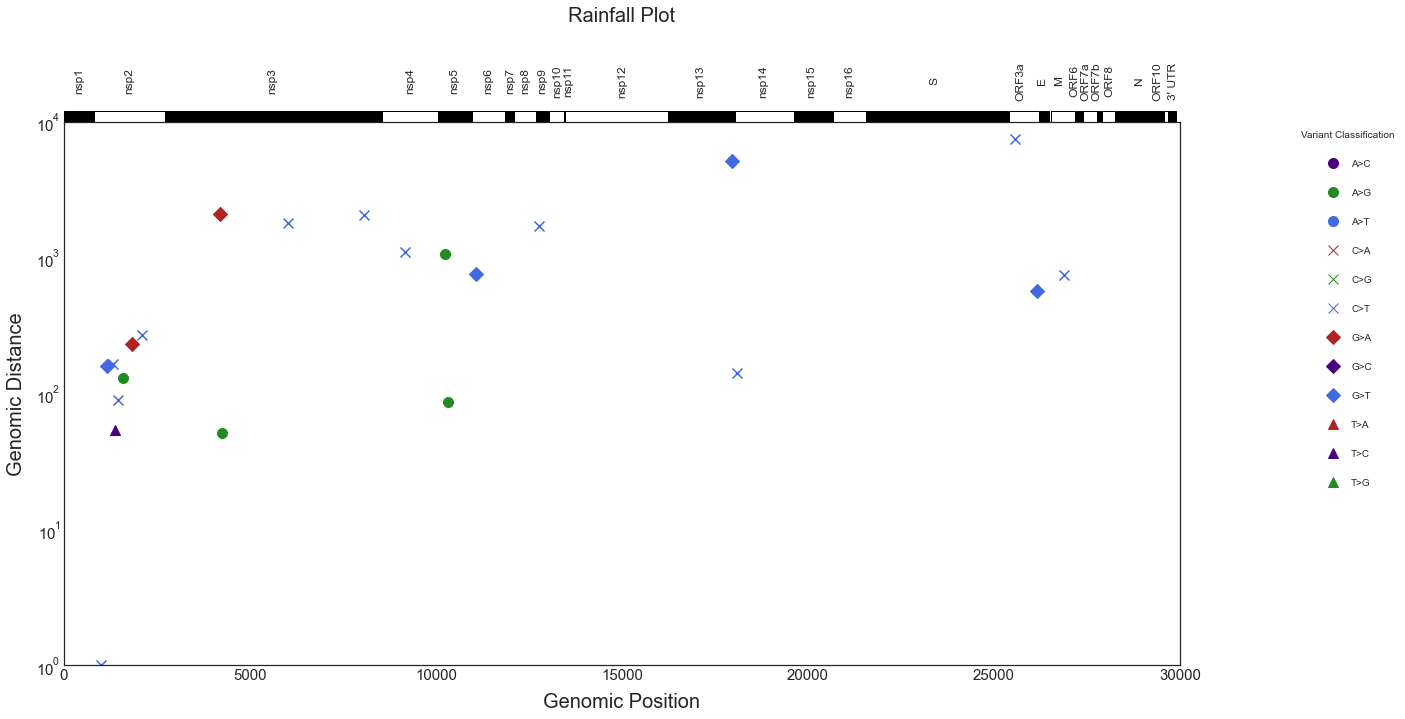

In [45]:
rainfall_plot_population(clade="V", aaf_limit=0.005)

# Individual Genome Rainfall Plot with Reference Genome Annotation Map


In [38]:
def rainfall_plot_individual(clade, sequence_header):
    reference_dict = {"A": "o","C": "x", "G": "D" , "T":"^" }
    alternate_dict = {"A": "firebrick","C": "indigo", "G": "forestgreen" , "T":"royalblue"}

    variants = read_vcf(clade)

    vcf = variants.iloc[:, 1:5]
    vcf[sequence_header] = variants[sequence_header]
    filter_vcf = vcf[vcf[sequence_header] != 0]
    filtered_df = pd.DataFrame(columns = ['position', 'reference', 'alternate'])
    filtered_df['reference'] = filter_vcf['REF']
    filtered_df['alternate'] = filter_vcf['ALT']
    filtered_df['position'] = filter_vcf['POS']
    filtered_df.reset_index(inplace=True)

    filtered_distance = [1]
    for i in range(1, len(filtered_df)):
        filtered_distance.append(filtered_df.iloc[i,0] - filtered_df.iloc[i-1,0])


    fig, ax = plt.subplots(figsize=(20, 10))
    for mut in range(len(filtered_df)):
        marker = reference_dict[filtered_df.loc[mut, 'reference']]
        color = alternate_dict[str(filtered_df.loc[mut, 'alternate'][0])]
        ax.scatter(filtered_df.loc[mut,"position"], filtered_distance[mut], c=color, marker=marker, s=100)

    ax.set_yscale("log")
    ax.set_xlim([0, 30000])
    ax.set_ylim([1, 10000])
    ax.set_title("Rainfall Plot", pad=100, size=20)
    ax.set_xlabel("Genomic Position", labelpad=10, size=20)
    ax.set_ylabel("Genomic Distance", labelpad=10, size=20)
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.tick_params(axis='both', which='minor', labelsize=15)

    A_C = mlines.Line2D([], [], color='indigo', marker='o', linestyle='None',
                              markersize=15, label='A>C')
    A_G = mlines.Line2D([], [], color='forestgreen', marker='o', linestyle='None',
                              markersize=15, label='A>G')
    A_T = mlines.Line2D([], [], color='royalblue', marker='o', linestyle='None',
                              markersize=15, label='A>T')

    C_A = mlines.Line2D([], [], color='firebrick', marker='X', linestyle='None',
                              markersize=15, label='C>A')
    C_G = mlines.Line2D([], [], color='forestgreen', marker='X', linestyle='None',
                              markersize=15, label='C>G')
    C_T = mlines.Line2D([], [], color='royalblue', marker='X', linestyle='None',
                              markersize=15, label='C>T')

    G_A = mlines.Line2D([], [], color='firebrick', marker='D', linestyle='None',
                              markersize=15, label='G>A')
    G_C = mlines.Line2D([], [], color='indigo', marker='D', linestyle='None',
                              markersize=15, label='G>C')
    G_T = mlines.Line2D([], [], color='royalblue', marker='D', linestyle='None',
                              markersize=15, label='G>T')

    T_A = mlines.Line2D([], [], color='firebrick', marker='^', linestyle='None',
                              markersize=15, label='T>A')
    T_C = mlines.Line2D([], [], color='indigo', marker='^', linestyle='None',
                              markersize=15, label='T>C')
    T_G = mlines.Line2D([], [], color='forestgreen', marker='^', linestyle='None',
                              markersize=15, label='T>G')

    fig.patch.set_facecolor('white')

    ax.text(400, 20000, "nsp1", horizontalalignment='center', verticalalignment='center', rotation=90, size=12)
    ax.add_patch(patches.Rectangle((1, 10000),805,2000,linewidth=1,edgecolor='black',facecolor='black', label="nsp1", clip_on=False))
    ax.text(1762, 20000, "nsp2", horizontalalignment='center', verticalalignment='center', rotation=90, size=12)
    ax.add_patch(patches.Rectangle((806, 10000),1913,2000,linewidth=1,edgecolor='black',facecolor='none', label="nsp2", clip_on=False))
    ax.text(5600, 20000, "nsp3", horizontalalignment='center', verticalalignment='center', rotation=90, size=12)
    ax.add_patch(patches.Rectangle((2720, 10000),5834,2000,linewidth=1,edgecolor='black',facecolor='black', label="nsp3", clip_on=False))

    ax.text(9300, 20000, "nsp4", horizontalalignment='center', verticalalignment='center', rotation=90, size=12)
    ax.add_patch(patches.Rectangle((8555, 10000),1499,2000,linewidth=1,edgecolor='black',facecolor='none', label="nsp4", clip_on=False))
    ax.text(10500, 20000, "nsp5", horizontalalignment='center', verticalalignment='center', rotation=90, size=12)
    ax.add_patch(patches.Rectangle((10055, 10000),917,2000,linewidth=1,edgecolor='black',facecolor='black', label="nsp5", clip_on=False))
    ax.text(11400, 20000, "nsp6", horizontalalignment='center', verticalalignment='center', rotation=90, size=12)
    ax.add_patch(patches.Rectangle((10973, 10000),869,2000,linewidth=1,edgecolor='black',facecolor='none', label="nsp6", clip_on=False))
    ax.text(12000, 20000, "nsp7", horizontalalignment='center', verticalalignment='center', rotation=90, size=12)
    ax.add_patch(patches.Rectangle((11843, 10000),248,2000,linewidth=1,edgecolor='black',facecolor='black', label="nsp7", clip_on=False))
    ax.text(12400, 20000, "nsp8", horizontalalignment='center', verticalalignment='center', rotation=90, size=12)
    ax.add_patch(patches.Rectangle((12092, 10000),593,2000,linewidth=1,edgecolor='black',facecolor='none', label="nsp8", clip_on=False))
    ax.text(12850, 20000, "nsp9", horizontalalignment='center', verticalalignment='center', rotation=90, size=12)
    ax.add_patch(patches.Rectangle((12686, 10000),338,2000,linewidth=1,edgecolor='black',facecolor='black', label="nsp9", clip_on=False))
    ax.text(13250, 20000, "nsp10", horizontalalignment='center', verticalalignment='center', rotation=90, size=12)
    ax.add_patch(patches.Rectangle((13025, 10000),416,2000,linewidth=1,edgecolor='black',facecolor='none', label="nsp10", clip_on=False))
    ax.text(13550, 20000, "nsp11", horizontalalignment='center', verticalalignment='center', rotation=90, size=12)
    ax.add_patch(patches.Rectangle((13442, 10000),38,2000,linewidth=1,edgecolor='black',facecolor='black', label="nsp11", clip_on=False))

    ax.text(15000, 20000, "nsp12", horizontalalignment='center', verticalalignment='center', rotation=90, size=12)
    ax.add_patch(patches.Rectangle((13480, 10000),2768,2000,linewidth=1,edgecolor='black',facecolor='none', label="nsp12", clip_on=False))
    ax.text(17100, 20000, "nsp13", horizontalalignment='center', verticalalignment='center', rotation=90, size=12)
    ax.add_patch(patches.Rectangle((16237, 10000),1802,2000,linewidth=1,edgecolor='black',facecolor='black', label="nsp13", clip_on=False))
    ax.text(18800, 20000, "nsp14", horizontalalignment='center', verticalalignment='center', rotation=90, size=12)
    ax.add_patch(patches.Rectangle((18040, 10000),1580,2000,linewidth=1,edgecolor='black',facecolor='none', label="nsp14", clip_on=False))
    ax.text(20100, 20000, "nsp15", horizontalalignment='center', verticalalignment='center', rotation=90, size=12)
    ax.add_patch(patches.Rectangle((19621, 10000),1037,2000,linewidth=1,edgecolor='black',facecolor='black', label="nsp15", clip_on=False))
    ax.text(21100, 20000, "nsp16", horizontalalignment='center', verticalalignment='center', rotation=90, size=12)
    ax.add_patch(patches.Rectangle((20659, 10000),893,2000,linewidth=1,edgecolor='black',facecolor='none', label="nsp16", clip_on=False))

    ax.text(23400, 20000, "S", horizontalalignment='center', verticalalignment='center', rotation=90, size=12)
    ax.add_patch(patches.Rectangle((21563, 10000),3821,2000,linewidth=1,edgecolor='black',facecolor='black', label="S", clip_on=False))
    ax.text(25700, 20000, "ORF3a", horizontalalignment='center', verticalalignment='center', rotation=90, size=12)
    ax.add_patch(patches.Rectangle((25393, 10000),827,2000,linewidth=1,edgecolor='black',facecolor='none', label="ORF3a", clip_on=False))
    ax.text(26300, 20000, "E", horizontalalignment='center', verticalalignment='center', rotation=90, size=12)
    ax.add_patch(patches.Rectangle((26245, 10000),227,2000,linewidth=1,edgecolor='black',facecolor='black', label="E", clip_on=False))
    ax.text(26750, 20000, "M",  horizontalalignment='center', verticalalignment='center',rotation=90, size=12)
    ax.add_patch(patches.Rectangle((26523, 10000),668,2000,linewidth=1,edgecolor='black',facecolor='none', label="M", clip_on=False))
    ax.text(27150, 20000, "ORF6",  horizontalalignment='center', verticalalignment='center',rotation=90, size=12)
    ax.add_patch(patches.Rectangle((27202, 10000),185,2000,linewidth=1,edgecolor='black',facecolor='black', label="ORF6", clip_on=False))
    ax.text(27450, 20000, "ORF7a",  horizontalalignment='center', verticalalignment='center',rotation=90, size=12)
    ax.add_patch(patches.Rectangle((27394, 10000),365,2000,linewidth=1,edgecolor='black',facecolor='none', label="ORF7a", clip_on=False))
    ax.text(27750, 20000, "ORF7b",  horizontalalignment='center', verticalalignment='center',rotation=90, size=12)
    ax.add_patch(patches.Rectangle((27756, 10000),131,2000,linewidth=1,edgecolor='black',facecolor='black', label="ORF7b", clip_on=False))
    ax.text(28100, 20000, "ORF8",  horizontalalignment='center', verticalalignment='center',rotation=90, size=12)
    ax.add_patch(patches.Rectangle((27894, 10000),365,2000,linewidth=1,edgecolor='black',facecolor='none', label="ORF8", clip_on=False))
    ax.text(28900, 20000, "N",  horizontalalignment='center', verticalalignment='center',rotation=90, size=12)
    ax.add_patch(patches.Rectangle((28274, 10000),1259,2000,linewidth=1,edgecolor='black',facecolor='black', label="N", clip_on=False))
    ax.text(29400, 20000, "ORF10",  horizontalalignment='center', verticalalignment='center',rotation=90, size=12)
    ax.add_patch(patches.Rectangle((29558, 10000),116,2000,linewidth=1,edgecolor='black',facecolor='none', label="ORF10", clip_on=False))
    ax.text(29800, 20000, "3' UTR",  horizontalalignment='center', verticalalignment='center',rotation=90, size=12)
    ax.add_patch(patches.Rectangle((29675, 10000),228,2000,linewidth=1,edgecolor='black',facecolor='black', label="3' UTR", clip_on=False))

    plt.legend(handles=[A_C, A_G, A_T, C_A, C_G, C_T, G_A, G_C, G_T, T_A, T_C, T_G], title='Variant Classification', bbox_to_anchor=(1.2, 1), labelspacing=2)
    plt.show()

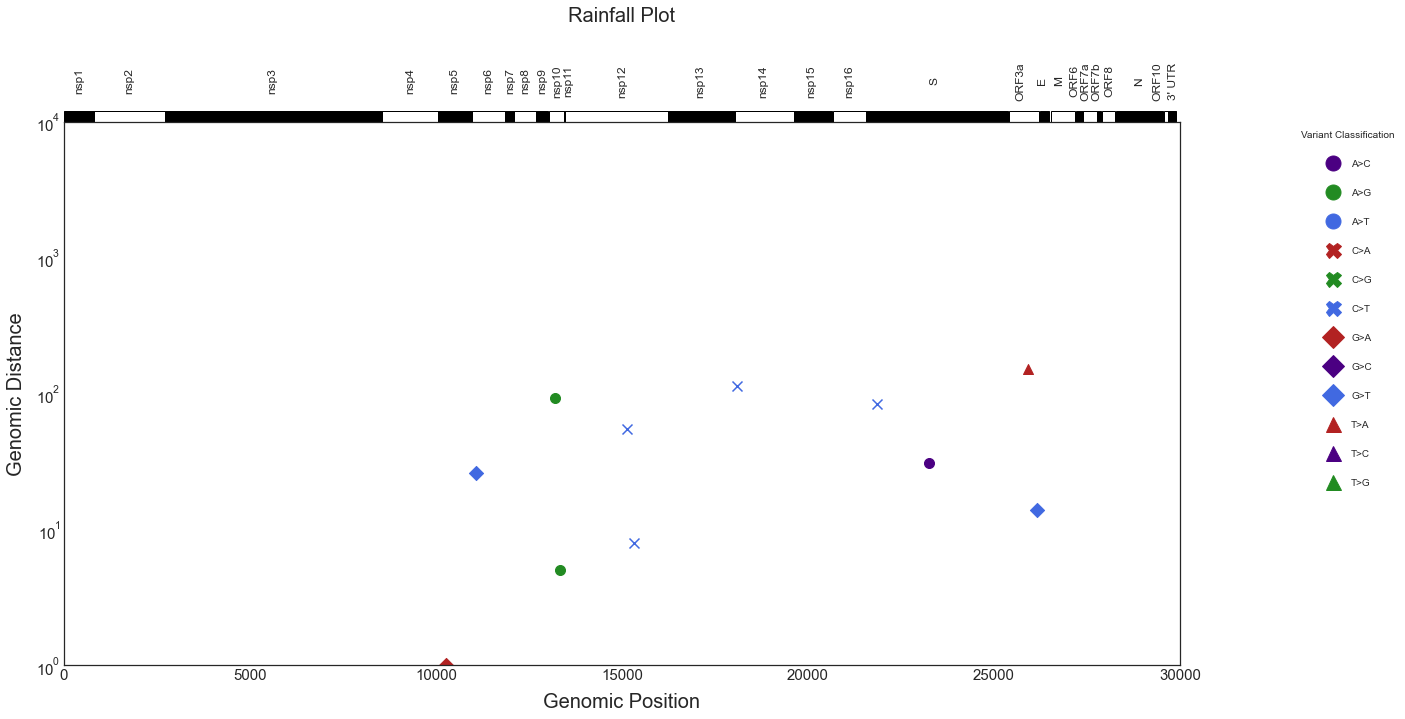

In [39]:
rainfall_plot_individual(clade = "V", 
                         sequence_header = "hCoV-19/Germany/SL-SU-10427348/2020|EPI_ISL_707948|2020-03-14")

# Mutation Plot 

Let me know if you think the auto scale function to adjust figure size is useful. Since some clades have lots more sequences than others, I auto scale the plot so that the height increases. However, the increase can lead to longer graphs that make it easier to see individual points, but may be unwieldly.

In [10]:
def mutation_landscape(clade):
    reference_dict = {"A": "o","C": "x", "G": "D" , "T":"^" }
    alternate_dict = {"A": "firebrick","C": "indigo", "G": "forestgreen" , "T":"royalblue"}

    df = read_vcf(clade = clade)
    filtered_df = df.copy().iloc[:, 9:].T

    foo = [x.split("|")[-1] for x in filtered_df.index]

    dates = []
    for d in foo:
        try:
            dates.append(pd.to_datetime(d).date())
        except:
            dates.append(0)
    filtered_df.index = dates
    filtered_df.drop(filtered_df.index[[i for i, x in enumerate(dates) if x == 0]], inplace=True)
    filtered_df.sort_index(inplace=True)
    dates = [x.replace(day=1) for x in list(filtered_df.index)]
    month_index = collections.OrderedDict()
    date_count = Counter(dates)
    
    #fig, ax = plt.subplots(figsize=(16,np.ceil((filtered_df.shape[0]/3000) * 8 )))
    fig, ax = plt.subplots(figsize=(16,12))
    for sequence in tqdm(range(len(filtered_df))):
        rows = filtered_df.iloc[sequence, : ]
        rows = rows[rows>0]
        if len(rows) < 1:
            pass
        else:
            for mutation in list(rows.index):
                try:
                    marker = reference_dict[df.loc[mutation, 'REF']]

                    color = alternate_dict[df.loc[mutation, 'ALT']]
                    plt.scatter(df.loc[mutation, "POS"],sequence,  c=color, marker=marker)
                except:
                    pass

    ax.set_xlim([0, 30000])
    ax.set_ylim([1, filtered_df.shape[0]])
    ax.set_title("Clade " + str(clade) + " Mutation Landscape Plot (n="+ str(len(filtered_df)) + ")", pad=100)
    ax.set_xlabel("Genomic Position", labelpad=10)
    ax.set_ylabel("Date", labelpad=10)
    ax.set_yticks([sum(list(date_count.values())[0:i[0]]) for i in enumerate(list(date_count.values()))])
    ax.set_yticklabels(list(date_count.keys()))
    fig.patch.set_facecolor('white')
    
    A_C = mlines.Line2D([], [], color='indigo', marker='o', linestyle='None',
                              markersize=15, label='A>C')
    A_G = mlines.Line2D([], [], color='forestgreen', marker='o', linestyle='None',
                              markersize=15, label='A>G')
    A_T = mlines.Line2D([], [], color='royalblue', marker='o', linestyle='None',
                              markersize=15, label='A>T')

    C_A = mlines.Line2D([], [], color='firebrick', marker='X', linestyle='None',
                              markersize=15, label='C>A')
    C_G = mlines.Line2D([], [], color='forestgreen', marker='X', linestyle='None',
                              markersize=15, label='C>G')
    C_T = mlines.Line2D([], [], color='royalblue', marker='X', linestyle='None',
                              markersize=15, label='C>T')

    G_A = mlines.Line2D([], [], color='firebrick', marker='D', linestyle='None',
                              markersize=15, label='G>A')
    G_C = mlines.Line2D([], [], color='indigo', marker='D', linestyle='None',
                              markersize=15, label='G>C')
    G_T = mlines.Line2D([], [], color='royalblue', marker='D', linestyle='None',
                              markersize=15, label='G>T')

    T_A = mlines.Line2D([], [], color='firebrick', marker='^', linestyle='None',
                              markersize=15, label='T>A')
    T_C = mlines.Line2D([], [], color='indigo', marker='^', linestyle='None',
                              markersize=15, label='T>C')
    T_G = mlines.Line2D([], [], color='forestgreen', marker='^', linestyle='None',
                              markersize=15, label='T>G')
    

    #ax.text(11000, filtered_df.shape[0]+(filtered_df.shape[0]/20), "ORF1ab", horizontalalignment='center', verticalalignment='center', rotation=0)
    #ax.add_patch(patches.Rectangle((266, filtered_df.shape[0]+100),21300,len(filtered_df)/20,linewidth=1,edgecolor='black',facecolor='white', label="ORF1ab", clip_on=False))
    ax.text(400, filtered_df.shape[0]+(filtered_df.shape[0]/10), "nsp1", horizontalalignment='center', verticalalignment='center', rotation=90)
    ax.add_patch(patches.Rectangle((1, filtered_df.shape[0]),805,len(filtered_df)/20,linewidth=1,edgecolor='black',facecolor='black', label="nsp1", clip_on=False))
    ax.text(1762, filtered_df.shape[0]+(filtered_df.shape[0]/10), "nsp2", horizontalalignment='center', verticalalignment='center', rotation=90)
    ax.add_patch(patches.Rectangle((806, filtered_df.shape[0]),1913,len(filtered_df)/20,linewidth=1,edgecolor='black',facecolor='none', label="nsp2", clip_on=False))
    ax.text(5600, filtered_df.shape[0]+(filtered_df.shape[0]/10), "nsp3", horizontalalignment='center', verticalalignment='center', rotation=90)
    ax.add_patch(patches.Rectangle((2720, filtered_df.shape[0]),5834,len(filtered_df)/20,linewidth=1,edgecolor='black',facecolor='black', label="nsp3", clip_on=False))

    ax.text(9300, filtered_df.shape[0]+(filtered_df.shape[0]/10), "nsp4", horizontalalignment='center', verticalalignment='center', rotation=90)
    ax.add_patch(patches.Rectangle((8555, filtered_df.shape[0]),1499,len(filtered_df)/20,linewidth=1,edgecolor='black',facecolor='none', label="nsp4", clip_on=False))
    ax.text(10500, filtered_df.shape[0]+(filtered_df.shape[0]/10), "nsp5", horizontalalignment='center', verticalalignment='center', rotation=90)
    ax.add_patch(patches.Rectangle((10055, filtered_df.shape[0]),917,len(filtered_df)/20,linewidth=1,edgecolor='black',facecolor='black', label="nsp5", clip_on=False))
    ax.text(11400, filtered_df.shape[0]+(filtered_df.shape[0]/10), "nsp6", horizontalalignment='center', verticalalignment='center', rotation=90)
    ax.add_patch(patches.Rectangle((10973, filtered_df.shape[0]),869,len(filtered_df)/20,linewidth=1,edgecolor='black',facecolor='none', label="nsp6", clip_on=False))
    ax.text(12000, filtered_df.shape[0]+(filtered_df.shape[0]/10), "nsp7", horizontalalignment='center', verticalalignment='center', rotation=90)
    ax.add_patch(patches.Rectangle((11843, filtered_df.shape[0]),248,len(filtered_df)/20,linewidth=1,edgecolor='black',facecolor='black', label="nsp7", clip_on=False))
    ax.text(12400, filtered_df.shape[0]+(filtered_df.shape[0]/10), "nsp8", horizontalalignment='center', verticalalignment='center', rotation=90)
    ax.add_patch(patches.Rectangle((12092, filtered_df.shape[0]),593,len(filtered_df)/20,linewidth=1,edgecolor='black',facecolor='none', label="nsp8", clip_on=False))
    ax.text(12850, filtered_df.shape[0]+(filtered_df.shape[0]/10), "nsp9", horizontalalignment='center', verticalalignment='center', rotation=90)
    ax.add_patch(patches.Rectangle((12686, filtered_df.shape[0]),338,len(filtered_df)/20,linewidth=1,edgecolor='black',facecolor='black', label="nsp9", clip_on=False))
    ax.text(13250, filtered_df.shape[0]+(filtered_df.shape[0]/10), "nsp10", horizontalalignment='center', verticalalignment='center', rotation=90)
    ax.add_patch(patches.Rectangle((13025, filtered_df.shape[0]),416,len(filtered_df)/20,linewidth=1,edgecolor='black',facecolor='none', label="nsp10", clip_on=False))
    ax.text(13550, filtered_df.shape[0]+(filtered_df.shape[0]/10), "nsp11", horizontalalignment='center', verticalalignment='center', rotation=90)
    ax.add_patch(patches.Rectangle((13442, filtered_df.shape[0]),38,len(filtered_df)/20,linewidth=1,edgecolor='black',facecolor='black', label="nsp11", clip_on=False))

    ax.text(15000, filtered_df.shape[0]+(filtered_df.shape[0]/10), "nsp12", horizontalalignment='center', verticalalignment='center', rotation=90)
    ax.add_patch(patches.Rectangle((13480, filtered_df.shape[0]),2768,len(filtered_df)/20,linewidth=1,edgecolor='black',facecolor='none', label="nsp12", clip_on=False))
    ax.text(17100, filtered_df.shape[0]+(filtered_df.shape[0]/10), "nsp13", horizontalalignment='center', verticalalignment='center', rotation=90)
    ax.add_patch(patches.Rectangle((16237, filtered_df.shape[0]),1802,len(filtered_df)/20,linewidth=1,edgecolor='black',facecolor='black', label="nsp13", clip_on=False))
    ax.text(18800, filtered_df.shape[0]+(filtered_df.shape[0]/10), "nsp14", horizontalalignment='center', verticalalignment='center', rotation=90)
    ax.add_patch(patches.Rectangle((18040, filtered_df.shape[0]),1580,len(filtered_df)/20,linewidth=1,edgecolor='black',facecolor='none', label="nsp14", clip_on=False))
    ax.text(20100, filtered_df.shape[0]+(filtered_df.shape[0]/10), "nsp15", horizontalalignment='center', verticalalignment='center', rotation=90)
    ax.add_patch(patches.Rectangle((19621, filtered_df.shape[0]),1037,len(filtered_df)/20,linewidth=1,edgecolor='black',facecolor='black', label="nsp15", clip_on=False))
    ax.text(21100, filtered_df.shape[0]+(filtered_df.shape[0]/10), "nsp16", horizontalalignment='center', verticalalignment='center', rotation=90)
    ax.add_patch(patches.Rectangle((20659, filtered_df.shape[0]),893,len(filtered_df)/20,linewidth=1,edgecolor='black',facecolor='none', label="nsp16", clip_on=False))

    ax.text(23400, filtered_df.shape[0]+(filtered_df.shape[0]/10), "S", horizontalalignment='center', verticalalignment='center', rotation=90)
    ax.add_patch(patches.Rectangle((21563, filtered_df.shape[0]),3821,len(filtered_df)/20,linewidth=1,edgecolor='black',facecolor='black', label="S", clip_on=False))
    ax.text(25700, filtered_df.shape[0]+(filtered_df.shape[0]/10), "ORF3a", horizontalalignment='center', verticalalignment='center', rotation=90)
    ax.add_patch(patches.Rectangle((25393, filtered_df.shape[0]),827,len(filtered_df)/20,linewidth=1,edgecolor='black',facecolor='none', label="ORF3a", clip_on=False))
    ax.text(26300, filtered_df.shape[0]+(filtered_df.shape[0]/10), "E", horizontalalignment='center', verticalalignment='center', rotation=90)
    ax.add_patch(patches.Rectangle((26245, filtered_df.shape[0]),227,len(filtered_df)/20,linewidth=1,edgecolor='black',facecolor='black', label="E", clip_on=False))
    ax.text(26750, filtered_df.shape[0]+(filtered_df.shape[0]/10), "M",  horizontalalignment='center', verticalalignment='center',rotation=90)
    ax.add_patch(patches.Rectangle((26523, filtered_df.shape[0]),668,len(filtered_df)/20,linewidth=1,edgecolor='black',facecolor='none', label="M", clip_on=False))
    ax.text(27150,filtered_df.shape[0]+(filtered_df.shape[0]/10), "ORF6",  horizontalalignment='center', verticalalignment='center',rotation=90)
    ax.add_patch(patches.Rectangle((27202, filtered_df.shape[0]),185,len(filtered_df)/20,linewidth=1,edgecolor='black',facecolor='black', label="ORF6", clip_on=False))
    ax.text(27450, filtered_df.shape[0]+(filtered_df.shape[0]/10), "ORF7a",  horizontalalignment='center', verticalalignment='center',rotation=90)
    ax.add_patch(patches.Rectangle((27394, filtered_df.shape[0]),365,len(filtered_df)/20,linewidth=1,edgecolor='black',facecolor='none', label="ORF7a", clip_on=False))
    ax.text(27750, filtered_df.shape[0]+(filtered_df.shape[0]/10), "ORF7b",  horizontalalignment='center', verticalalignment='center',rotation=90)
    ax.add_patch(patches.Rectangle((27756, filtered_df.shape[0]),131,len(filtered_df)/20,linewidth=1,edgecolor='black',facecolor='black', label="ORF7b", clip_on=False))
    ax.text(28100, filtered_df.shape[0]+(filtered_df.shape[0]/10), "ORF8",  horizontalalignment='center', verticalalignment='center',rotation=90)
    ax.add_patch(patches.Rectangle((27894, filtered_df.shape[0]),365,len(filtered_df)/20,linewidth=1,edgecolor='black',facecolor='none', label="ORF8", clip_on=False))
    ax.text(28900, filtered_df.shape[0]+(filtered_df.shape[0]/10), "N",  horizontalalignment='center', verticalalignment='center',rotation=90)
    ax.add_patch(patches.Rectangle((28274, filtered_df.shape[0]),1259,len(filtered_df)/20,linewidth=1,edgecolor='black',facecolor='black', label="N", clip_on=False))
    ax.text(29400, filtered_df.shape[0]+(filtered_df.shape[0]/10), "ORF10",  horizontalalignment='center', verticalalignment='center',rotation=90)
    ax.add_patch(patches.Rectangle((29558, filtered_df.shape[0]),116,len(filtered_df)/20,linewidth=1,edgecolor='black',facecolor='none', label="ORF10", clip_on=False))
    ax.text(29800, filtered_df.shape[0]+(filtered_df.shape[0]/10), "3' UTR",  horizontalalignment='center', verticalalignment='center',rotation=90)
    ax.add_patch(patches.Rectangle((29675, filtered_df.shape[0]),228,len(filtered_df)/20,linewidth=1,edgecolor='black',facecolor='black', label="3' UTR", clip_on=False))

    plt.legend(handles=[A_C, A_G, A_T, C_A, C_G, C_T, G_A, G_C, G_T, T_A, T_C, T_G], title='Variant Classification', bbox_to_anchor=(1.2, 1), labelspacing=2)
    plt.show()

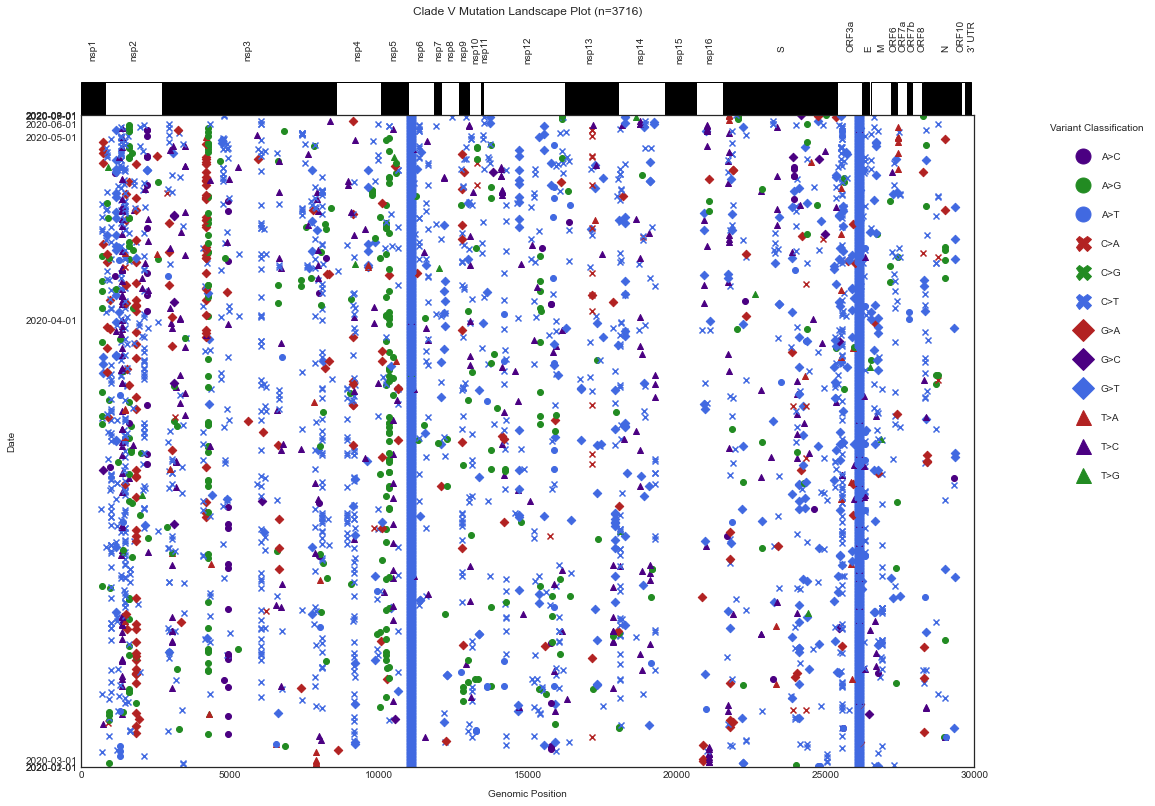

In [29]:
mutation_landscape(clade = "V")

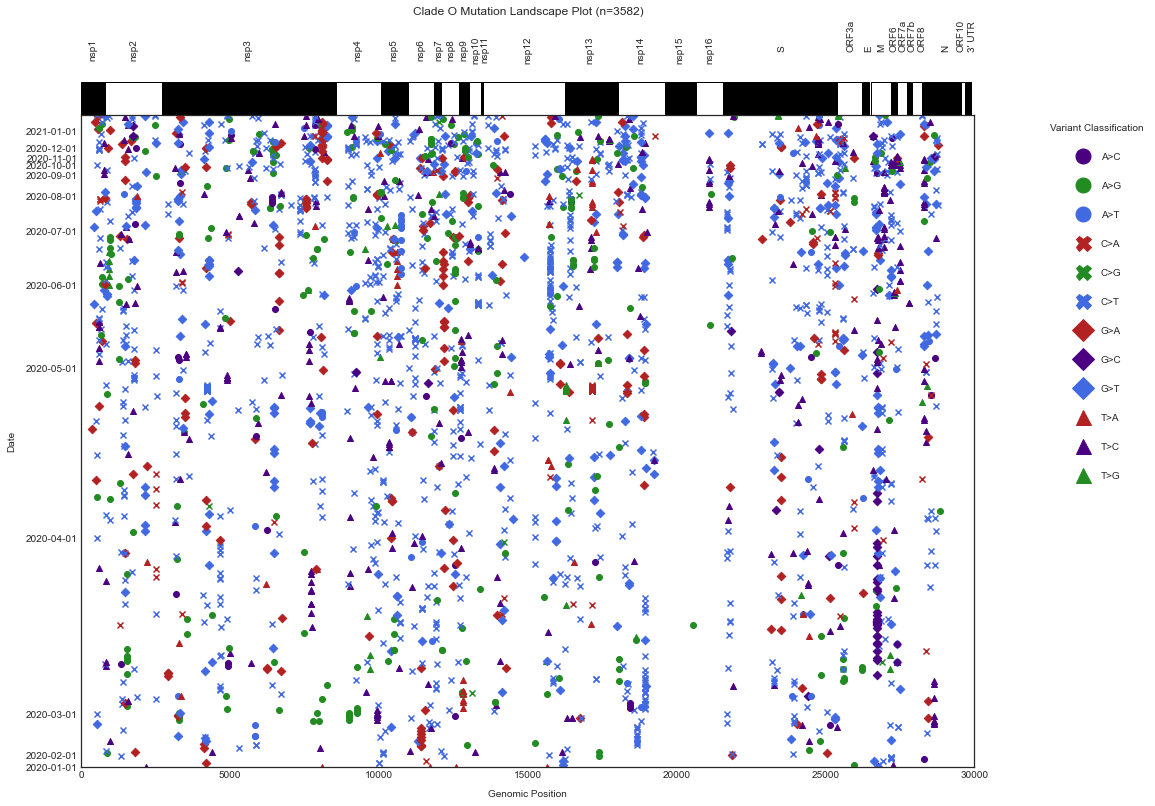

In [28]:
mutation_landscape(clade = "O")

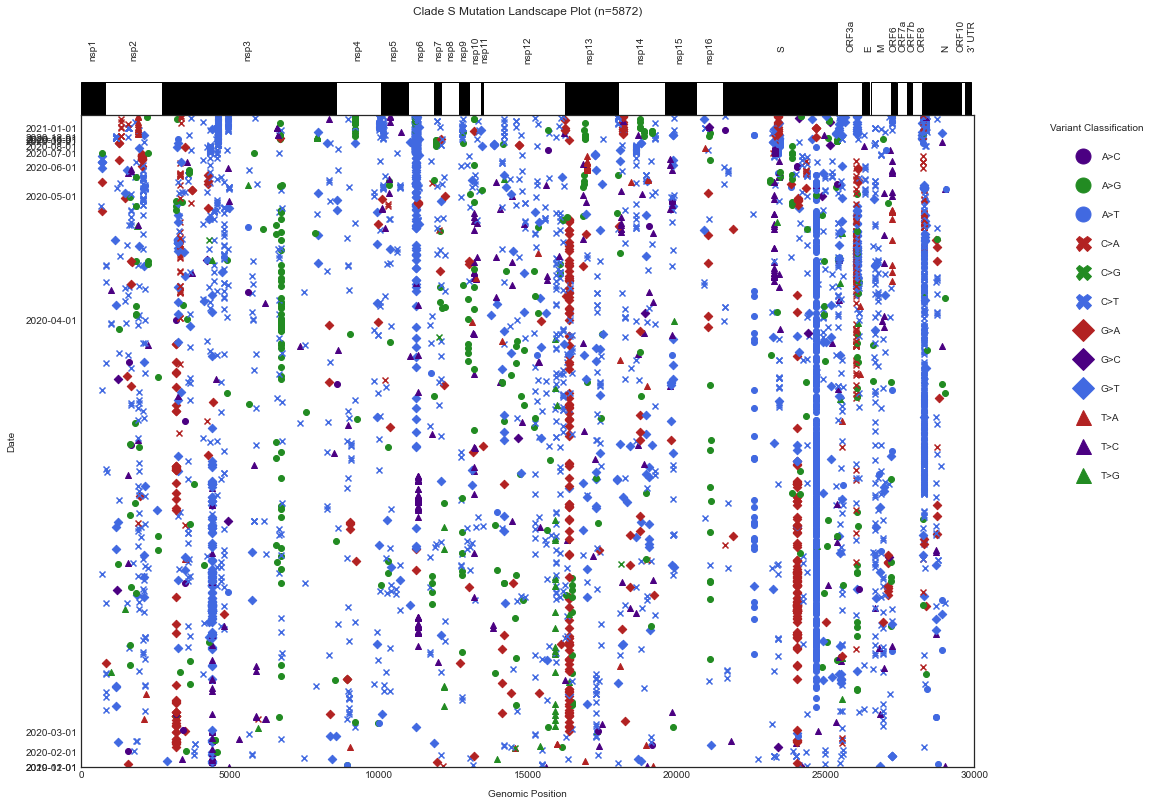

In [30]:
mutation_landscape(clade = "S")

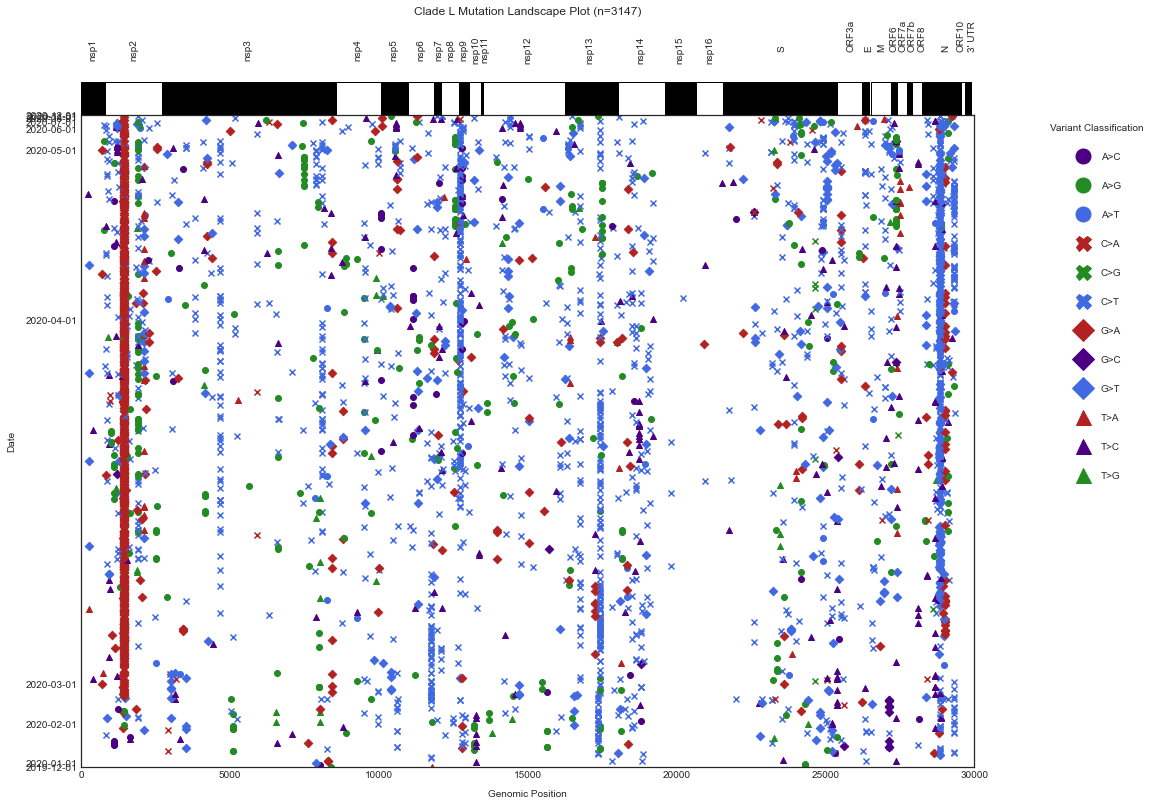

In [31]:
mutation_landscape(clade = "L")

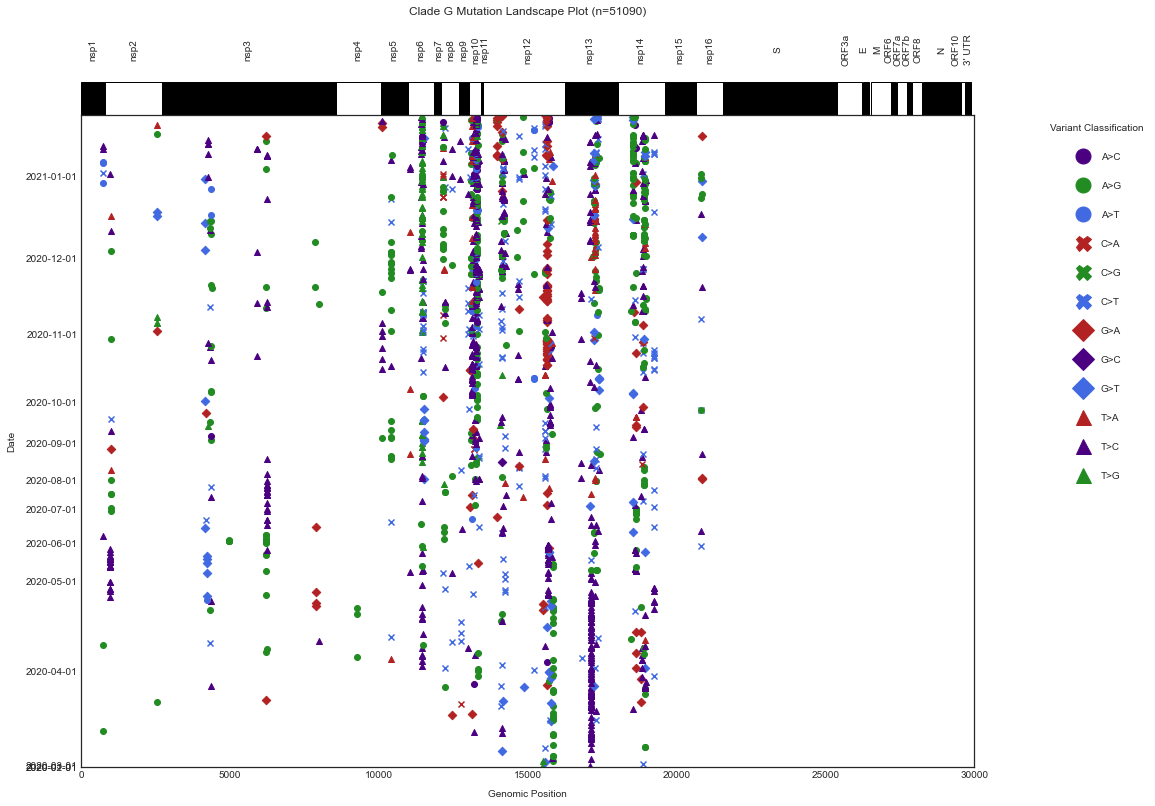

In [11]:
mutation_landscape(clade = "G")

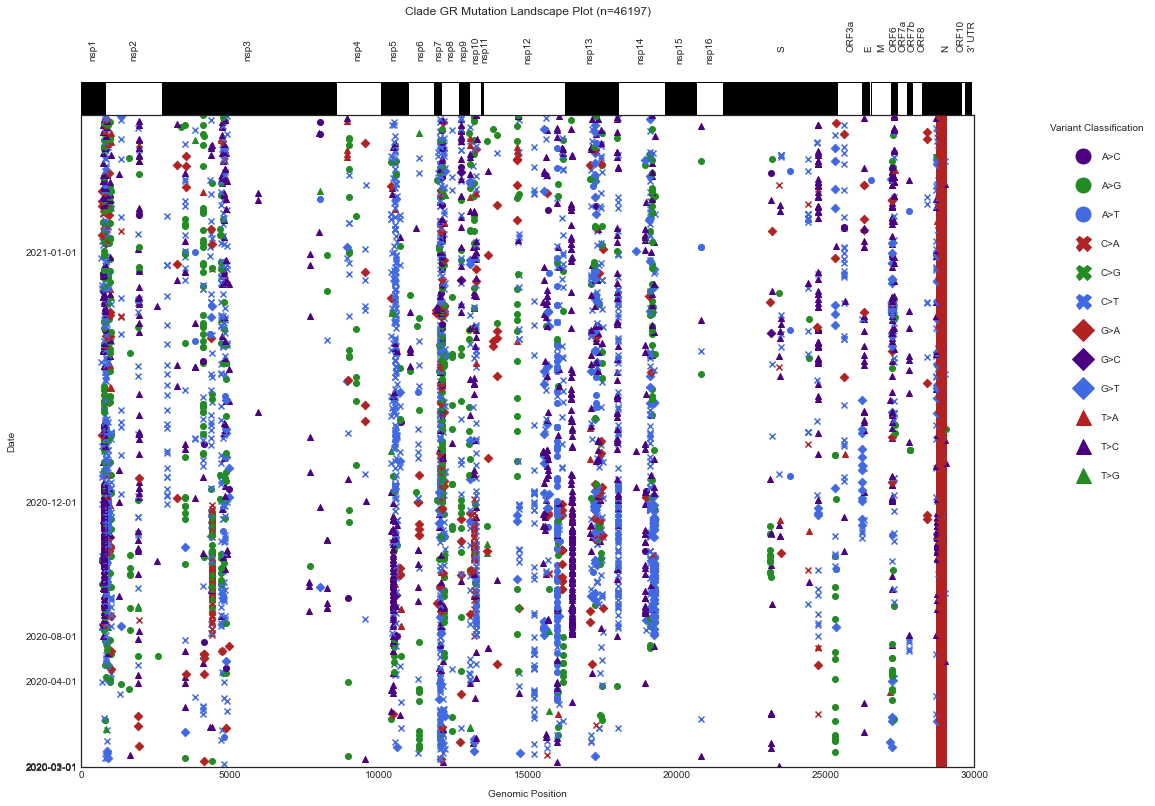

In [33]:
mutation_landscape(clade = "GR")

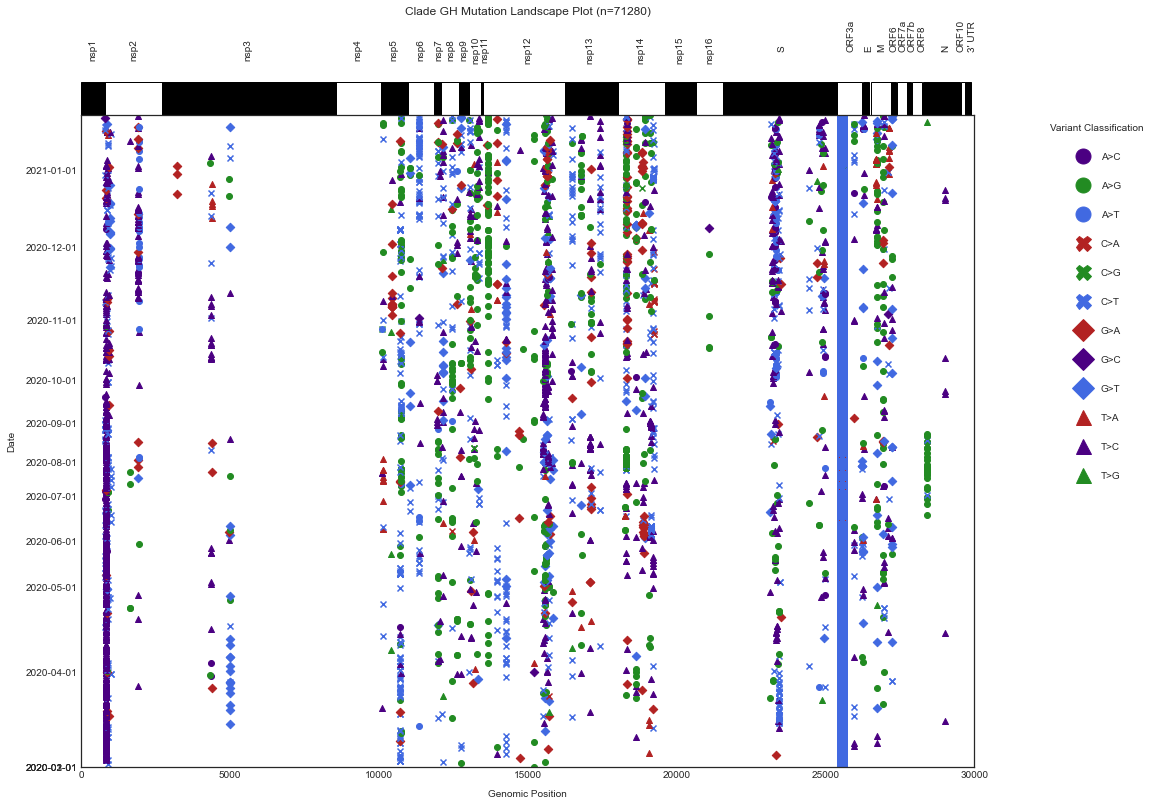

In [34]:
mutation_landscape(clade = "GH")

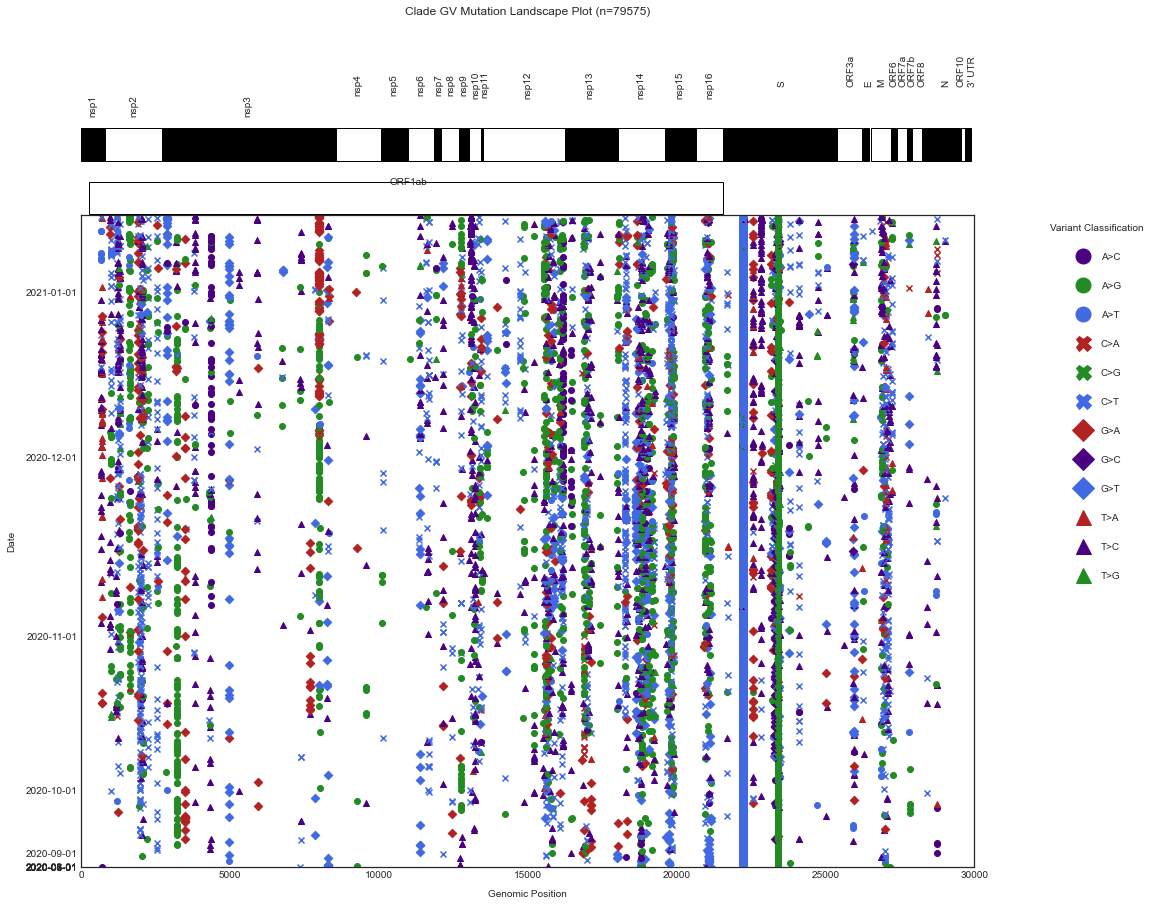

In [16]:
mutation_landscape(clade = "GV")

# Visualize mutation counts as a binned bar plot

In [36]:
def mutation_count(clade, bin_size = 1000):
    df = read_vcf(clade = clade)
    x = df['POS']
    y = df.iloc[:, 9:].sum(axis=1)

    ax = pd.cut(x, bins=list(range(0, 31000, bin_size)), include_lowest=True).value_counts(sort=False).plot.bar(rot=45, color="royalblue", figsize=(10,3))
    ax.set_xticklabels([str(x) + "-" + str(x + 999) for x in list(range(0, 31000, bin_size))] , ha="right")
    plt.title("Mutation Count Plot for Clade " + str(clade))
    plt.ylabel("Number of Unique Mutations")
    plt.xlabel("Genomic Region (bin size = " + str(bin_size) + ")")
    plt.show()

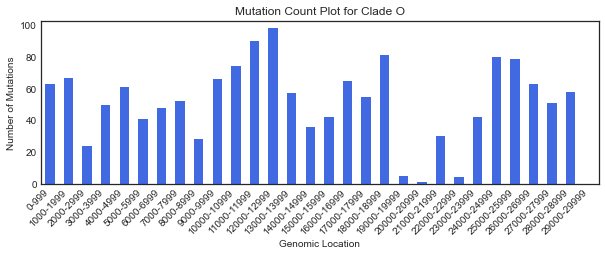

In [75]:
mutation_count(clade = "O", bin_size = 1000)

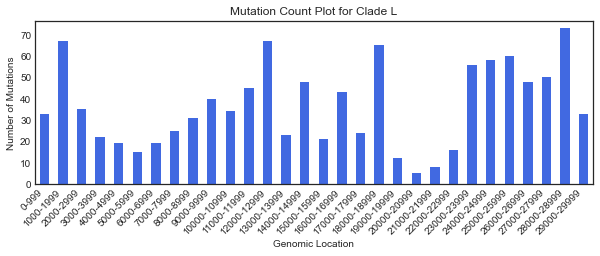

In [81]:
mutation_count(clade = "L", bin_size = 1000)

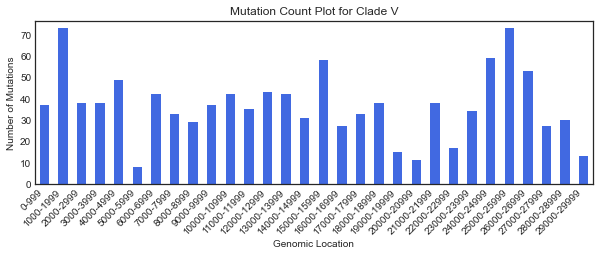

In [82]:
mutation_count(clade = "V", bin_size = 1000)

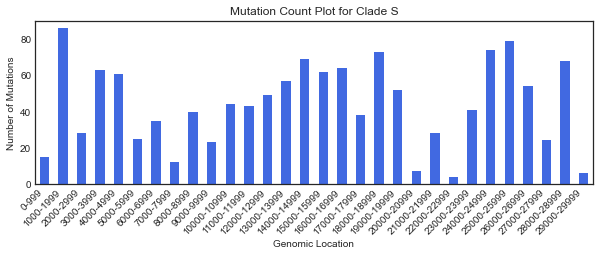

In [83]:
mutation_count(clade = "S", bin_size = 1000)

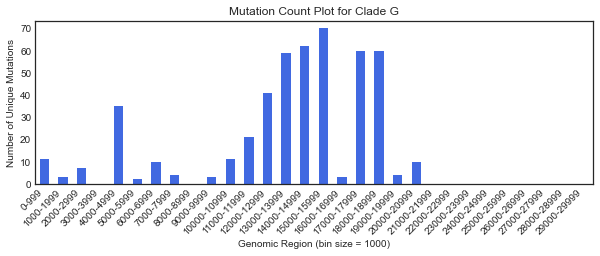

In [37]:
mutation_count(clade = "G", bin_size = 1000)

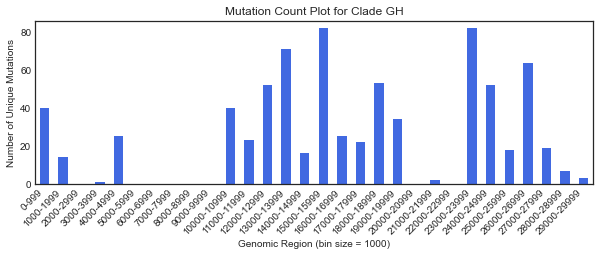

In [38]:
mutation_count(clade = "GH", bin_size = 1000)

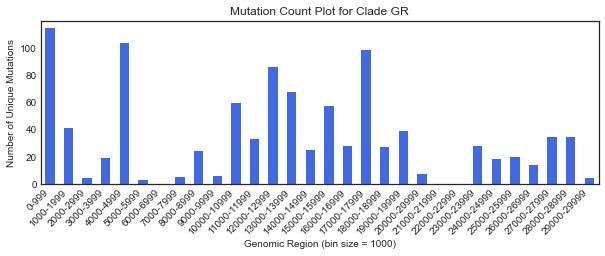

In [39]:
mutation_count(clade = "GR", bin_size = 1000)

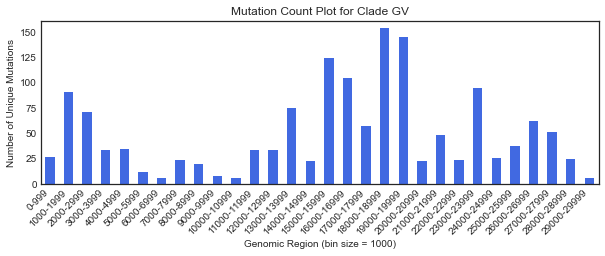

In [40]:
mutation_count(clade = "GV", bin_size = 1000)

# De Novo Extraction of Mutational Signatures

In [13]:
from sklearn.decomposition import NMF
from Bio.Seq import Seq
import nimfa

# Mutation Count Matrix

In [14]:
def mutation_count_matrix(clade):

    test = read_vcf(clade=clade)
    
    reference_genome =  str(next(SeqIO.parse(directory + "/MN996528_1.fasta", "fasta")).seq).upper()
    sbs_96 = pd.read_excel(directory + "/WGS_PCAWG.96.xlsx")
    classification = sbs_96.iloc[:, :2]
    for sequence in test.columns[10:]:
        classification[sequence] = 0
        slice_df = test[test[sequence] > 0].reset_index(drop=True)
        for row in range(len(slice_df)):

            if reference_genome[slice_df.loc[row, "POS"] - 1] in ["G", "A"]:

                trinucleotide_context = str(Seq(reference_genome[slice_df.loc[row, "POS"] - 2: slice_df.loc[row, "POS"] + 1]).reverse_complement())
                reference = str(Seq(slice_df.loc[row, "REF"]).reverse_complement())
                alternate = str(Seq(slice_df.loc[row, "ALT"]).reverse_complement()).split(",")[0]
                mutation_type = reference + ">" + alternate

                index = classification[(classification['Mutation type'] == mutation_type) & (classification['Trinucleotide'] == trinucleotide_context)].index[0]
                classification.loc[index, sequence] += 1

            else:

                trinucleotide_context = reference_genome[slice_df.loc[row, "POS"] - 2: slice_df.loc[row, "POS"] + 1]
                reference = slice_df.loc[row, "REF"]
                alternate = slice_df.loc[row, "ALT"].split(",")[0]
                mutation_type = reference + ">" + alternate

                index = classification[(classification['Mutation type'] == mutation_type) & (classification['Trinucleotide'] == trinucleotide_context)].index[0]
                classification.loc[index, sequence] += 1

    return classification

        
      

In [15]:
mutation_count_matrix("V")

Mutation type Trinucleotide  \
0            C>A           ACA   
1            C>A           ACC   
2            C>A           ACG   
3            C>A           ACT   
4            C>A           CCA   
..           ...           ...   
91           T>G           GTT   
92           T>G           TTA   
93           T>G           TTC   
94           T>G           TTG   
95           T>G           TTT   

    hCoV-19/Italy/LAZ-INMI1-cs/2020|EPI_ISL_410546|2020-01-31  \
0                                                   1           
1                                                   1           
2                                                   0           
3                                                   0           
4                                                   0           
..                                                ...           
91                                                  0           
92                                                  0           
93                                                  0           
94                                                  0           
95                                                  0           

    hCoV-19/Finland/14M20/2020|EPI_ISL_418405|2020-03-14  \
0                                                   1      
1                                                   1      
2                                                   0      
3                                                   0      
4                                                   0      
..                                                ...      
91                                                  0      
92                                                  0      
93                                                  0      
94                                                  0      
95                                                  0      

    hCoV-19/France/ARA-11036/2020|EPI_ISL_418432|2020-03-18  \
0                                                   1         
1                                                   1         
2                                                   0         
3                                                   0         
4                                                   0         
..                                                ...         
91                                                  0         
92                                                  0         
93                                                  0         
94                                                  0         
95                                                  0         

    hCoV-19/Australia/VIC116/2020|EPI_ISL_419721|2020-03-19  \
0                                                   1         
1                                                   1         
2                                                   0         
3                                                   0         
4                                                   0         
..                                                ...         
91                                                  0         
92                                                  0         
93                                                  0         
94                                                  0         
95                                                  0         

    hCoV-19/Australia/VIC120/2020|EPI_ISL_419722|2020-03-19  \
0                                                   1         
1                                                   1         
2                                                   0         
3                                                   0         
4                                                   0         
..                                                ...         
91                                                  0         
92                                                  0         
93         

# Mutation Spectra

In [16]:
def mutation_spectra(clade):
    df = mutation_count_matrix(clade)

    sbs_96 = df.iloc[:, :2].reset_index(drop=True)
    values = df.iloc[:, 2:]
    spectra = values.div(values.sum(axis=0), axis=1).fillna(0).reset_index(drop=True)

    return pd.concat([sbs_96, spectra], ignore_index=False, axis=1)

In [17]:
mutation_spectra("V")

Mutation type Trinucleotide  \
0            C>A           ACA   
1            C>A           ACC   
2            C>A           ACG   
3            C>A           ACT   
4            C>A           CCA   
..           ...           ...   
91           T>G           GTT   
92           T>G           TTA   
93           T>G           TTC   
94           T>G           TTG   
95           T>G           TTT   

    hCoV-19/Italy/LAZ-INMI1-cs/2020|EPI_ISL_410546|2020-01-31  \
0                                                 0.5           
1                                                 0.5           
2                                                 0.0           
3                                                 0.0           
4                                                 0.0           
..                                                ...           
91                                                0.0           
92                                                0.0           
93                                                0.0           
94                                                0.0           
95                                                0.0           

    hCoV-19/Finland/14M20/2020|EPI_ISL_418405|2020-03-14  \
0                                                0.25      
1                                                0.25      
2                                                0.00      
3                                                0.00      
4                                                0.00      
..                                                ...      
91                                               0.00      
92                                               0.00      
93                                               0.00      
94                                               0.00      
95                                               0.00      

    hCoV-19/France/ARA-11036/2020|EPI_ISL_418432|2020-03-18  \
0                                            0.333333         
1                                            0.333333         
2                                            0.000000         
3                                            0.000000         
4                                            0.000000         
..                                                ...         
91                                           0.000000         
92                                           0.000000         
93                                           0.000000         
94                                           0.000000         
95                                           0.000000         

    hCoV-19/Australia/VIC116/2020|EPI_ISL_419721|2020-03-19  \
0                                                0.25         
1                                                0.25         
2                                                0.00         
3                                                0.00         
4                                                0.00         
..                                                ...         
91                                               0.00         
92                                               0.00         
93                                               0.00         
94                                               0.00         
95                                               0.00         

    hCoV-19/Australia/VIC120/2020|EPI_ISL_419722|2020-03-19  \
0                                                 0.5         
1                                                 0.5         
2                                                 0.0         
3                                                 0.0         
4                                                 0.0         
..                                                ...         
91                                                0.0         
92                                                0.0         
93         

# Non-negative Matrix Factorization Latent Dimensionality Selection

In [18]:
test = mutation_count_matrix("V")

In [19]:
rank_cands = range(5, 35, 5)
nmf = nimfa.Nmf(np.clip(test.iloc[:, 2:].values.T, 0, 1000), seed='random_vcol', max_iter=1000)
summary = nmf.estimate_rank(rank_range=rank_cands, n_run=1, what=['rss', 'dispersion', 'sparseness', 'evar'])

In [20]:
def nmf_statistics(clade, rank_start = 5, rank_end = 35, step = 5):

    test = mutation_count_matrix(clade)

    rank_cands = range(rank_start, rank_end, step)
    nmf = nimfa.Nmf(np.clip(test.iloc[:, 2:].values.T, 0, 1000), seed='random_vcol', max_iter=1000)
    summary = nmf.estimate_rank(rank_range= rank_cands, n_run=1, what=['rss', 'dispersion', 'sparseness', 'evar'])

    rss = [summary[rank]['rss'] for rank in rank_cands]
    disp = [summary[rank]['dispersion'] for rank in rank_cands]
    spar = [summary[rank]['sparseness'] for rank in rank_cands]
    spar_w, spar_h = zip(*spar)
    evar = [summary[rank]['evar'] for rank in rank_cands]

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,10))
    ax1.plot(rank_cands, rss, 'o-', label='RSS', linewidth=2, c='purple')
    ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=3, numpoints=1)

    ax2.plot(rank_cands, disp,'o-', label='Dispersion', linewidth=2)
    ax2.plot(rank_cands, spar_w, 'o-', label='Sparsity (Basis)', linewidth=2)
    ax2.plot(rank_cands, spar_h, 'o-', label='Sparsity (Mixture)', linewidth=2)
    ax2.plot(rank_cands, evar, 'o-', label='Explained variance', linewidth=2)
    ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=3, numpoints=1)
    ax2.set_xlabel("Rank", labelpad=30)
    plt.tight_layout()
    plt.show()

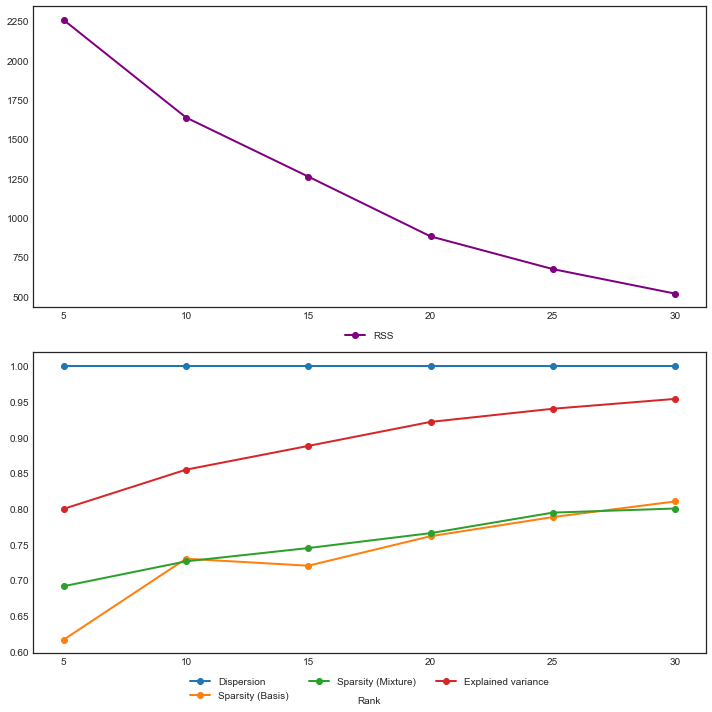

In [21]:
nmf_statistics("V")

# Reconstruction of De Novo Signatures compared to Original Mutational Profile

In [22]:
import scipy.spatial.distance as distance

In [23]:
def signature_reconstruction(clade, n_components):
    test = mutation_count_matrix(clade)
    model = NMF(n_components=n_components, init='random', random_state=0, solver='mu', max_iter= 10000)
    W = model.fit_transform(np.clip(test.iloc[:, 2:].values.T, 0, 1000))
    H = model.components_
    print("Cosine Similarity: " + str(1 - distance.cosine(test.iloc[:, 2:].values.T.sum(axis=0), model.inverse_transform(W).sum(axis=0))))
          
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 3))
          
    ax1.bar(range(96), test.iloc[:, 2:].values.T.sum(axis=0))
    ax1.set_title("Mutation Counts")
          
    ax2.bar(range(96), model.inverse_transform(W).sum(axis=0))
    ax2.set_title("Reconstructed Mutation Counts using " + str(n_components) + " de novo Extracted Signatures")

Cosine Similarity: 0.9997325853586735


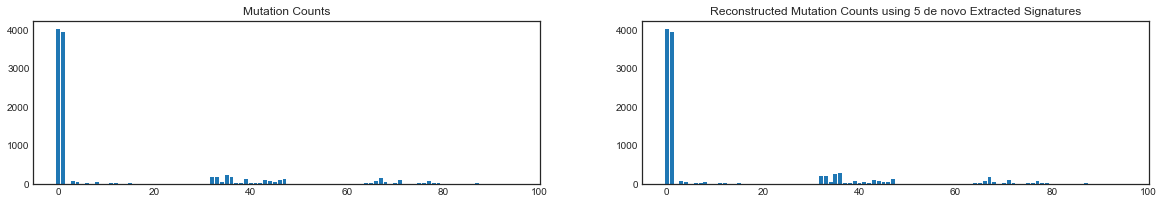

In [202]:
signature_reconstruction(clade = "V", n_components = 5)

Cosine Similarity: 0.9998494254787373


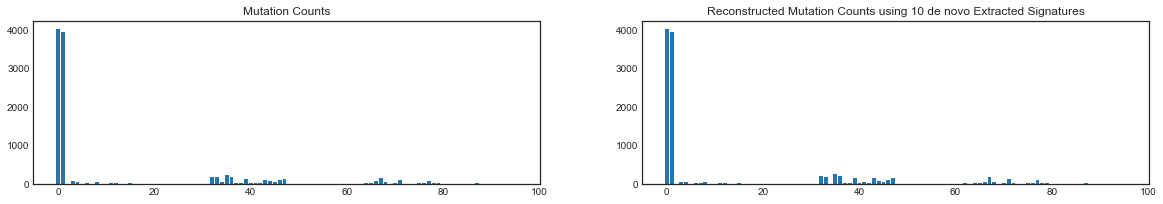

In [203]:
signature_reconstruction(clade = "V", n_components = 10)

Cosine Similarity: 0.9999179792841184


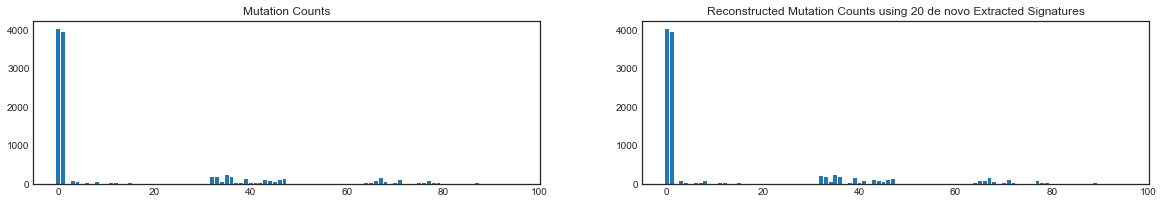

In [204]:
signature_reconstruction(clade = "V", n_components = 20)

Cosine Similarity: 0.9998743091409453


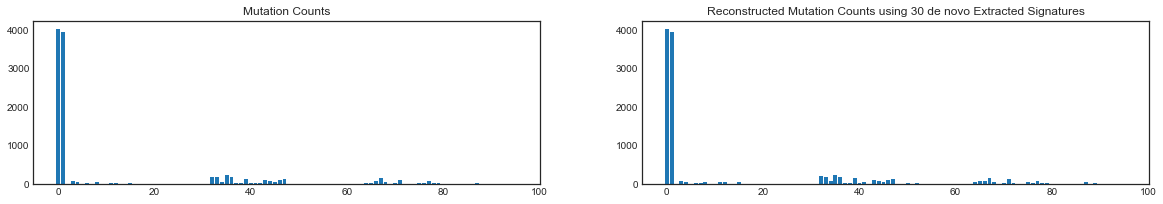

In [205]:
signature_reconstruction(clade = "V", n_components = 30)

# Compare 10 de novo extracted signatures with the reconstructed weighted sum of all de novo signatures signatures 

In [62]:
def signature_deconstruct(clade):

    test = mutation_count_matrix(clade)
    model = NMF(n_components=10, init='random', random_state=0, solver='mu', max_iter= 10000)
    W = model.fit_transform(np.clip(test.iloc[:, 2:].values.T, 0, 1000))
    H = model.components_

    sig_components = pd.DataFrame(H)
    spectra = sig_components.div(sig_components.sum(axis=1), axis=0).fillna(0).reset_index(drop=True)

    fig = plt.figure(figsize=(20,5))
    gs = fig.add_gridspec(3,5)

    ax_main = fig.add_subplot(gs[0, :])
    reconstructed_profile = pd.DataFrame(model.inverse_transform(W).sum(axis=0))
    ax_main.bar(range(0, 96),reconstructed_profile.div(reconstructed_profile.sum(axis=0), axis=1).fillna(0).reset_index(drop=True).values.T.tolist()[0])
    ax_main.set_title("Reconstructed Weighted Average of Mutational Signatures")
    ax_main.set_xlim(-1,96)

    ax1 = fig.add_subplot(gs[1, 0])
    ax1.bar(range(0, 96), spectra.iloc[0, :])
    ax1.set_title("Signature 1")
    ax1.set_xlim(-1,96)
    
    ax2 = fig.add_subplot(gs[1, 1])
    ax2.bar(range(0,96), spectra.iloc[1, :])
    ax2.set_title("Signature 2")
    ax2.set_xlim(-1,96)
    
    ax3 = fig.add_subplot(gs[1, 2])
    ax3.bar(range(0,96), spectra.iloc[2, :])
    ax3.set_title("Signature 3")
    ax3.set_xlim(-1,96)
    
    ax4 = fig.add_subplot(gs[1, 3])
    ax4.bar(range(0,96), spectra.iloc[3, :])
    ax4.set_title("Signature 4")
    ax4.set_xlim(-1,96)
    
    ax5 = fig.add_subplot(gs[1, 4])
    ax5.bar(range(0,96), spectra.iloc[4, :])
    ax5.set_title("Signature 5")
    ax5.set_xlim(-1,96)
    
    ax6 = fig.add_subplot(gs[2, 0])
    ax6.bar(range(0,96), spectra.iloc[5, :])
    ax6.set_title("Signature 6")
    ax6.set_xlim(-1,96)
    
    ax7 = fig.add_subplot(gs[2, 1])
    ax7.bar(range(0,96), spectra.iloc[6, :])
    ax7.set_title("Signature 7")
    ax1.set_xlim(-1,96)

    ax8 = fig.add_subplot(gs[2, 2])
    ax8.bar(range(0,96), spectra.iloc[7, :])
    ax8.set_title("Signature 8")
    ax1.set_xlim(-1,96)
    
    ax9 = fig.add_subplot(gs[2, 3])
    ax9.bar(range(0,96), spectra.iloc[8, :])
    ax9.set_title("Signature 9")
    ax1.set_xlim(-1,96)
    
    ax10 = fig.add_subplot(gs[2, 4])
    ax10.bar(range(0,96), spectra.iloc[9, :])
    ax10.set_title("Signature 10")
    ax1.set_xlim(-1,96)
    
    fig.tight_layout()
    plt.show()


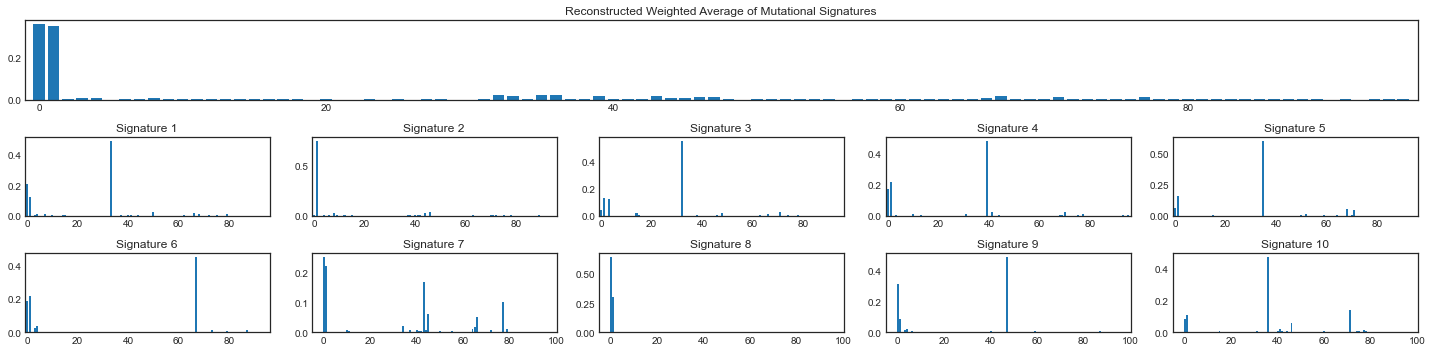

In [63]:
signature_deconstruct(clade="V")

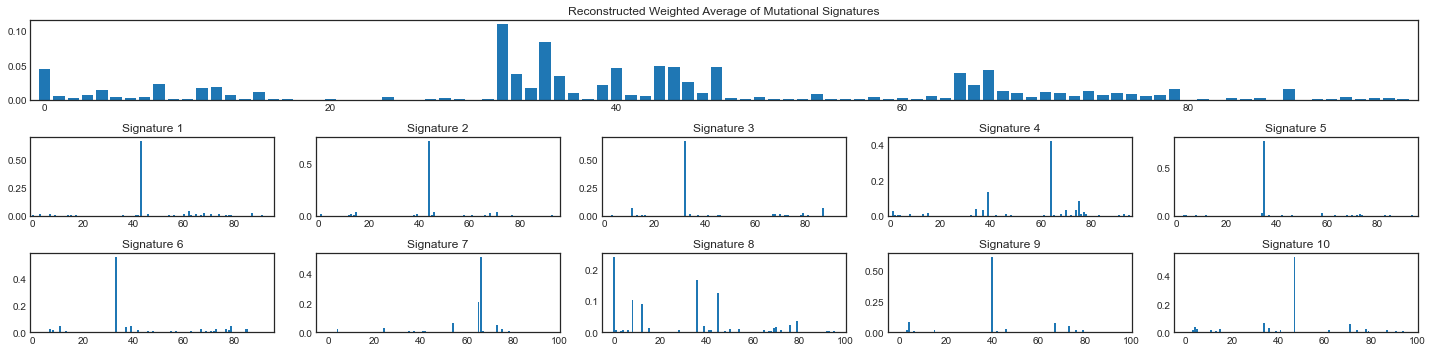

In [216]:
signature_deconstruct(clade="O")

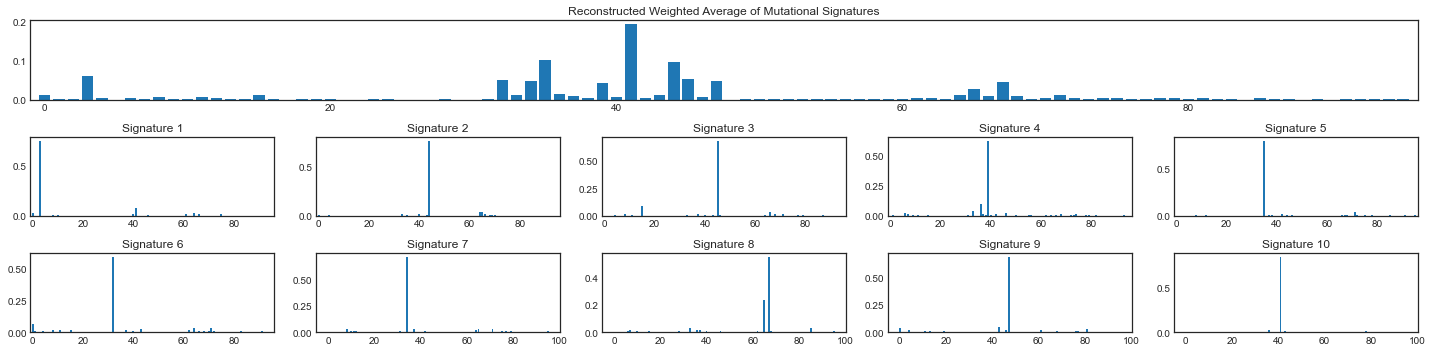

In [217]:
signature_deconstruct(clade="L")

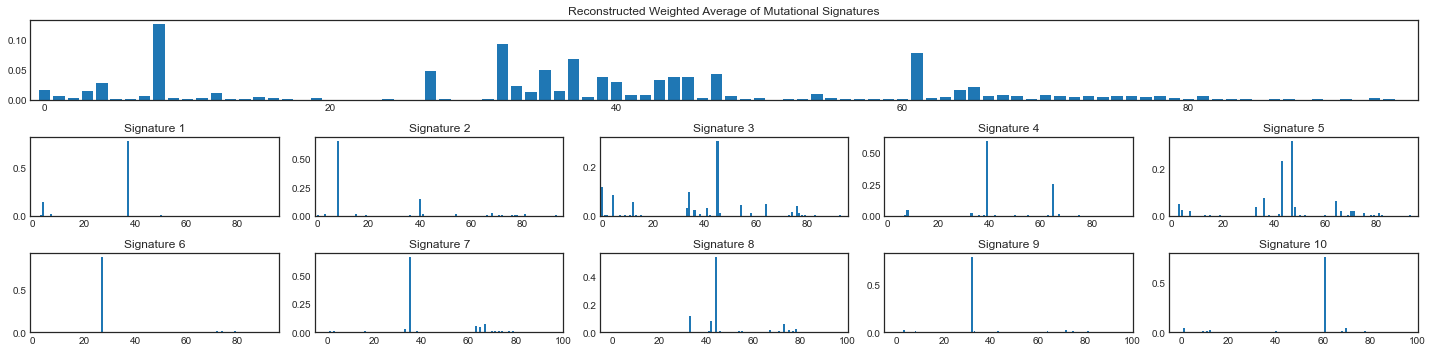

In [218]:
signature_deconstruct(clade="S")

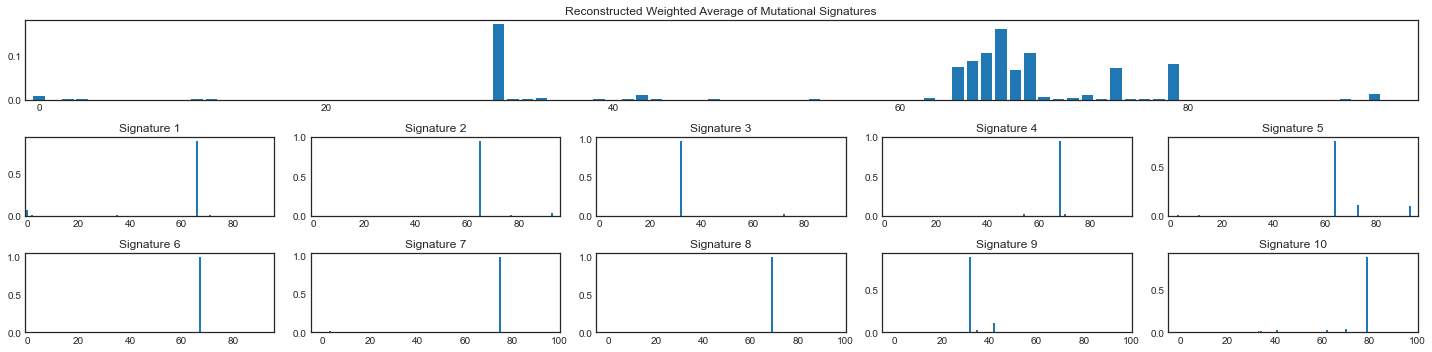

In [219]:
signature_deconstruct(clade="G")

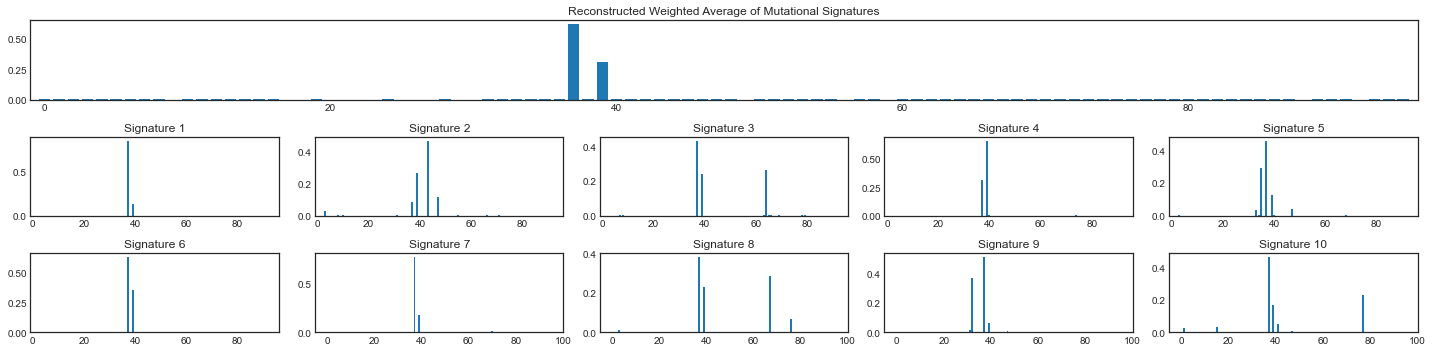

In [220]:
signature_deconstruct(clade="GR")

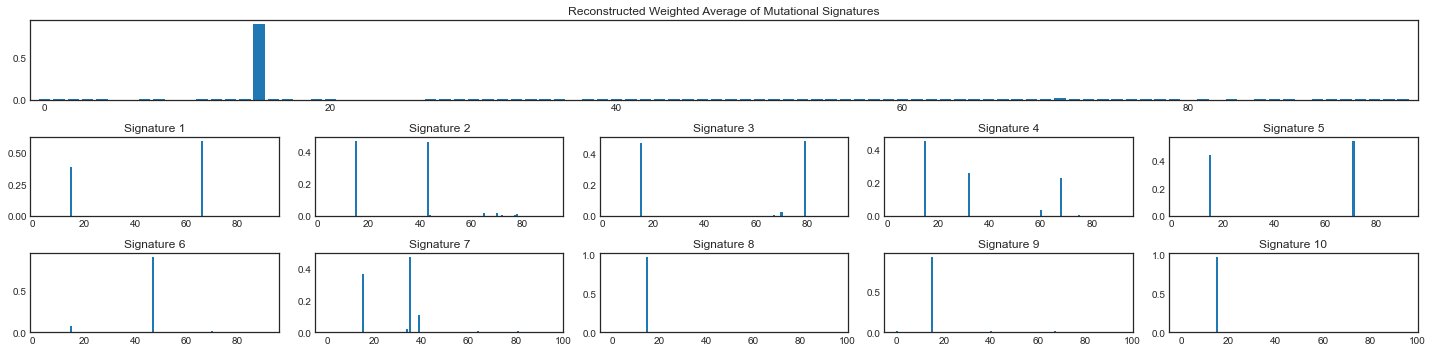

In [221]:
signature_deconstruct(clade="GH")

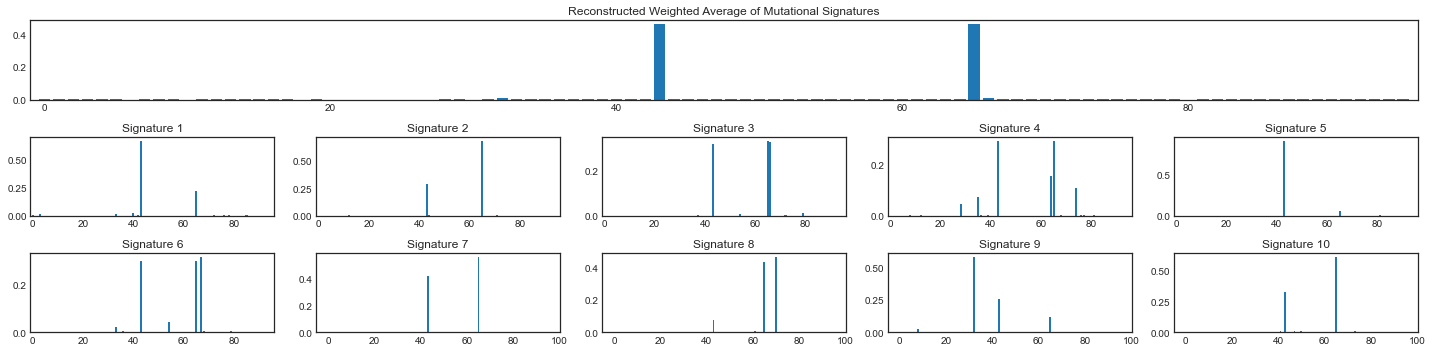

In [222]:
signature_deconstruct(clade="GV")

# Normalized Mean Weight of the Deconstructed Signatures 

In [66]:
def signature_weight(clade):
    test = mutation_count_matrix(clade)
    model = NMF(n_components=10, init='random', random_state=0, solver='mu', max_iter= 10000)
    W = model.fit_transform(np.clip(test.iloc[:, 2:].values.T, 0, 1000))
    H = model.components_
    plt.title("Normalized Mean Weight of Each De Novo Signature (n=10)")
    plt.bar(range(1,11), pd.DataFrame(W).mean(axis=0).div(pd.DataFrame(W).mean(axis=0).sum()))
    plt.show()

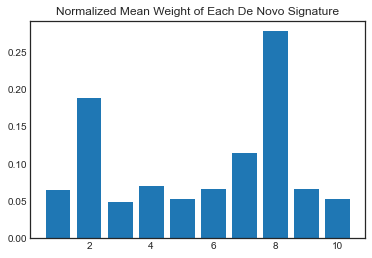

In [67]:
signature_weight(clade="V")

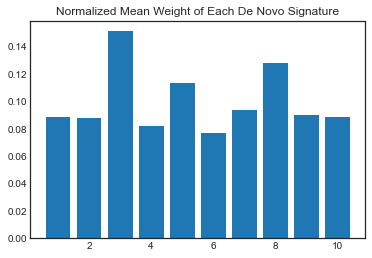

In [223]:
signature_weight(clade="O")

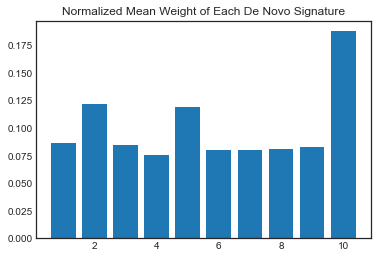

In [224]:
signature_weight(clade="L")

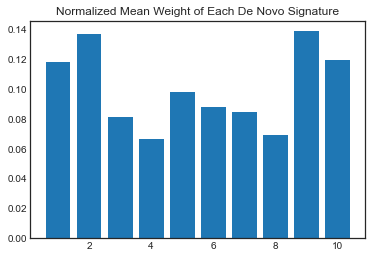

In [225]:
signature_weight(clade="S")

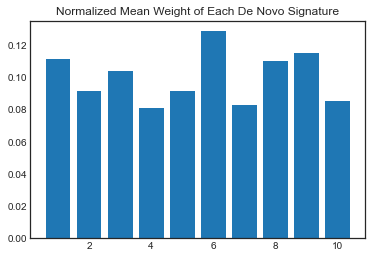

In [226]:
signature_weight(clade="G")

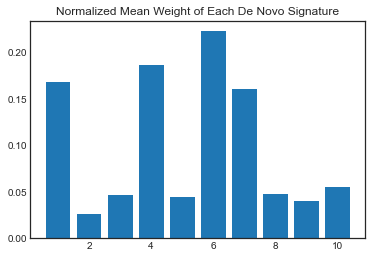

In [227]:
signature_weight(clade="GR")

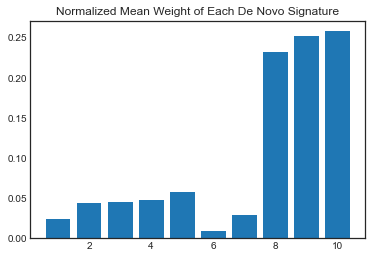

In [228]:
signature_weight(clade="GH")

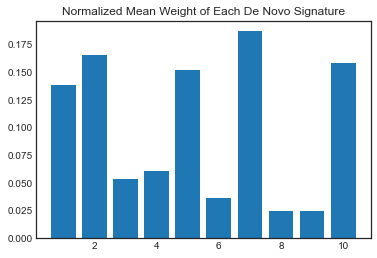

In [229]:
signature_weight(clade="GV")

# Pearson and Spearman Correlation between the De Novo Signatures

In [105]:
def signature_correlation(clade, method = "spearman"):

    test = mutation_count_matrix(clade)
    model = NMF(n_components=10, init='random', random_state=0, solver='mu', max_iter= 10000)
    W = model.fit_transform(np.clip(test.iloc[:, 2:].values.T, 0, 1000))
    H = model.components_
    
    sig_components = pd.DataFrame(H)
    spectra = sig_components.div(sig_components.sum(axis=1), axis=0).fillna(0).reset_index(drop=True)
    
    fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches

    ax.set_title(method.capitalize() + " Correlation of De Novo Signatures")
    sns.heatmap(data = spectra.T.corr(method=method),
               xticklabels = ["Signature " + str(x) for x in range(1,11)],
               yticklabels = ["Signature " + str(x) for x in range(1,11)],
               linewidths=.5,
               annot=True,
               cmap = "Reds",
               ax=ax)
    plt.yticks(rotation=0) 
    plt.show()

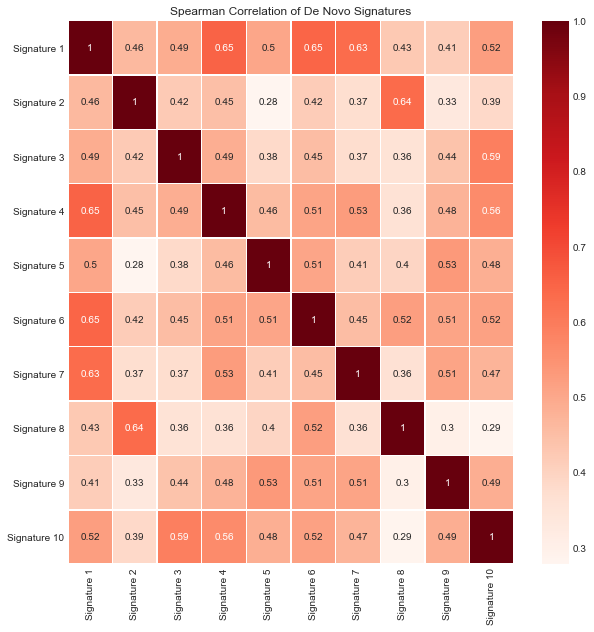

In [103]:
signature_correlation(clade="V", method = "spearman")

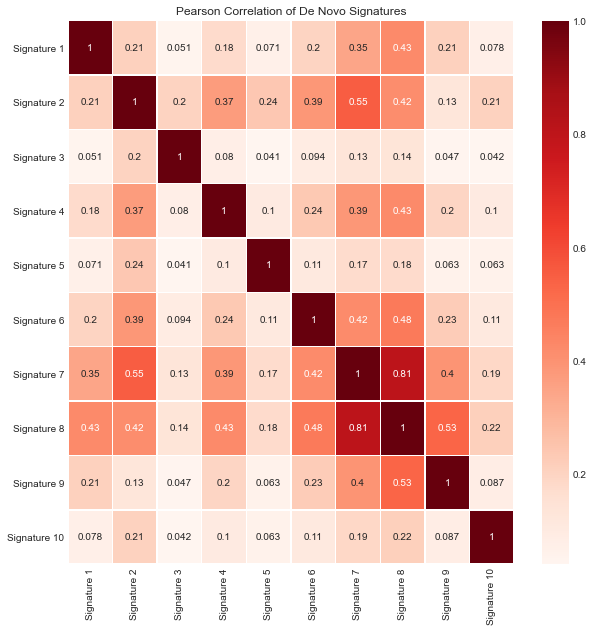

In [104]:
signature_correlation(clade="V", method = "pearson")

# Cosine Similarity between De Novo Signatures

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

In [114]:
def signature_cosine_similarity(clade):

    test = mutation_count_matrix(clade)
    model = NMF(n_components=10, init='random', random_state=0, solver='mu', max_iter= 10000)
    W = model.fit_transform(np.clip(test.iloc[:, 2:].values.T, 0, 1000))
    H = model.components_

    sig_components = pd.DataFrame(H)
    spectra = sig_components.div(sig_components.sum(axis=1), axis=0).fillna(0).reset_index(drop=True)
    
    similarities = cosine_similarity(spectra)
    
    fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches

    ax.set_title(method.capitalize() + " Correlation of De Novo Signatures")
    
    sns.heatmap(data = similarities,
               xticklabels = ["Signature " + str(x) for x in range(1,11)],
               yticklabels = ["Signature " + str(x) for x in range(1,11)],
               linewidths=.5,
               annot=True,
               cmap = "Reds",
               ax=ax)
    plt.yticks(rotation=0) 
    plt.show()

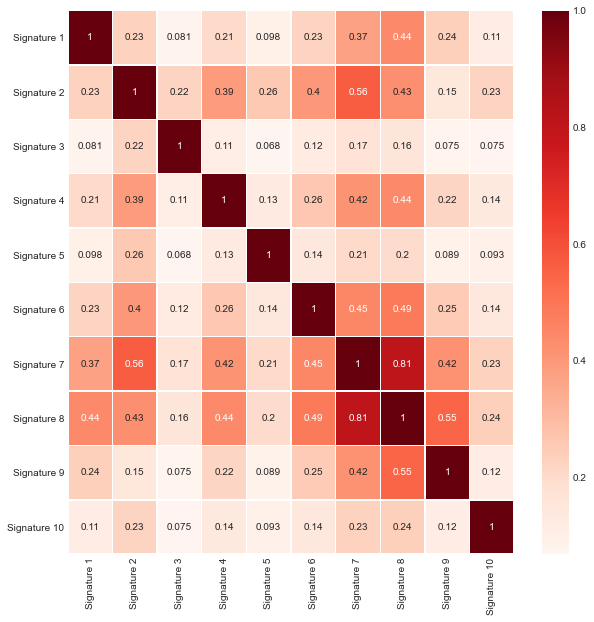

In [115]:
signature_cosine_similarity(clade = "V")

# Cosine Similarity to of De Novo Signatures Compared to Known Human SBS Signatures

In [200]:
def signature_comparison(clade):
    test = mutation_count_matrix(clade)
    model = NMF(n_components=10, init='random', random_state=0, solver='mu', max_iter= 10000)
    W = model.fit_transform(np.clip(test.iloc[:, 2:].values.T, 0, 1000))
    H = model.components_

    sig_components = pd.DataFrame(H)
    spectra = sig_components.div(sig_components.sum(axis=1), axis=0).fillna(0).reset_index(drop=True)
    sbs_96 = pd.read_excel(directory + "/COSMIC_Mutational_Signatures_v3.1.xlsx")


    g= sns.clustermap(data = cosine_similarity(sbs_96.iloc[:, 2:].T, spectra),
               linewidths=.5,
               annot=True,
               cmap = "Reds",
               xticklabels = ["Signature " + str(x) for x in range(1,11)],
               yticklabels = sbs_96.columns[2:],
               figsize = (10, 15),
               row_colors = ['red' if signature in ["SBS27", "SBS43", "SBS45", "SBS46", "SBS47", "SBS48", "SBS49",
                            "SBS50", "SBS51", "SBS52", "SBS53", "SBS54", "SBS55", "SBS56",
                            "SBS57", "SBS58", "SBS59", "SBS60"] else 'black' for signature in sbs_96.columns[2:]],
                    cbar_pos=(1.05, 0.065, 0.03, 0.74))
    g.ax_heatmap.set_title('Cosine Similarity of De Novo Signatures and Known Human SBS Signatures', pad = 200)

    g.ax_heatmap.set_xlabel("Clade " + clade + " De Novo Signatures")
    g.ax_heatmap.set_ylabel("Human SBS Signatures")

    plt.show()



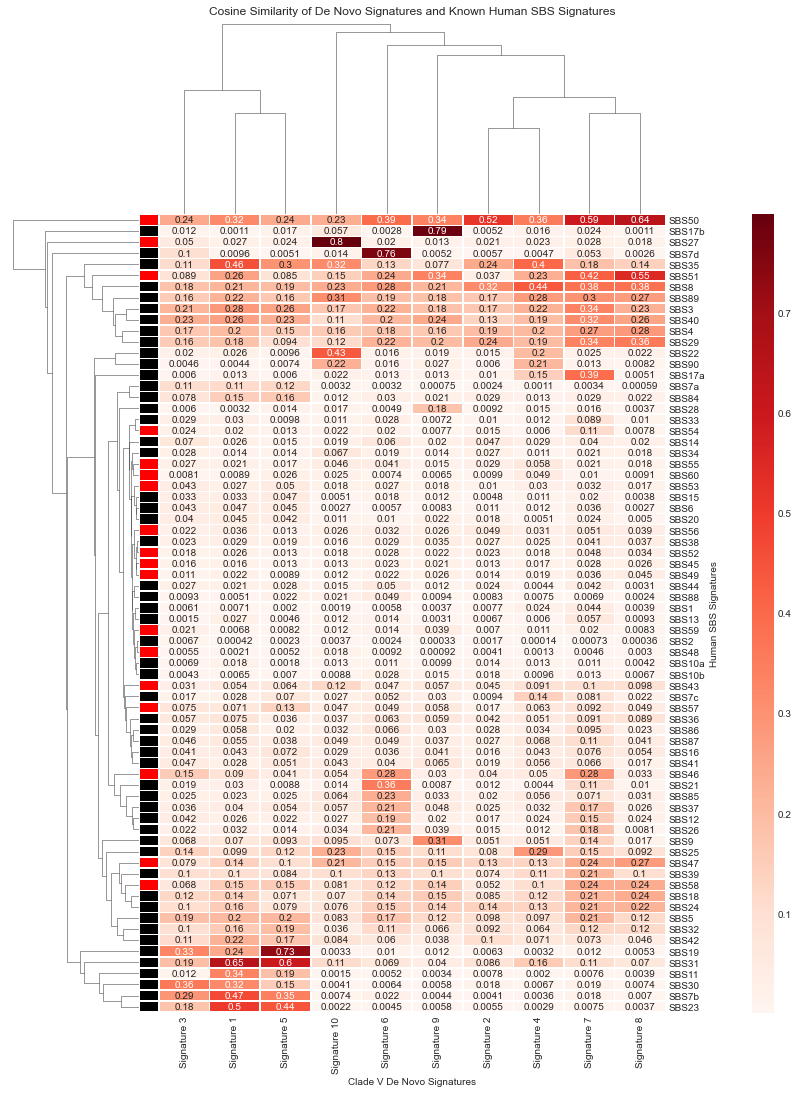

In [201]:
signature_comparison(clade= "V")

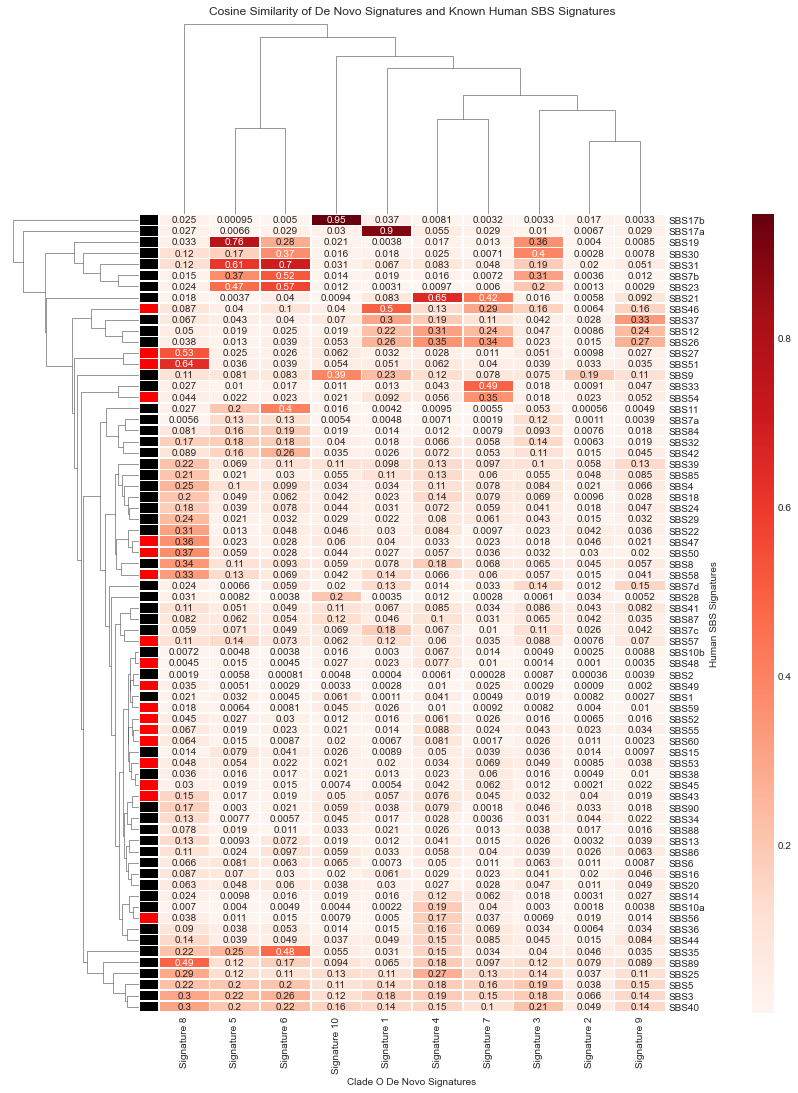

In [206]:
signature_comparison(clade= "O")

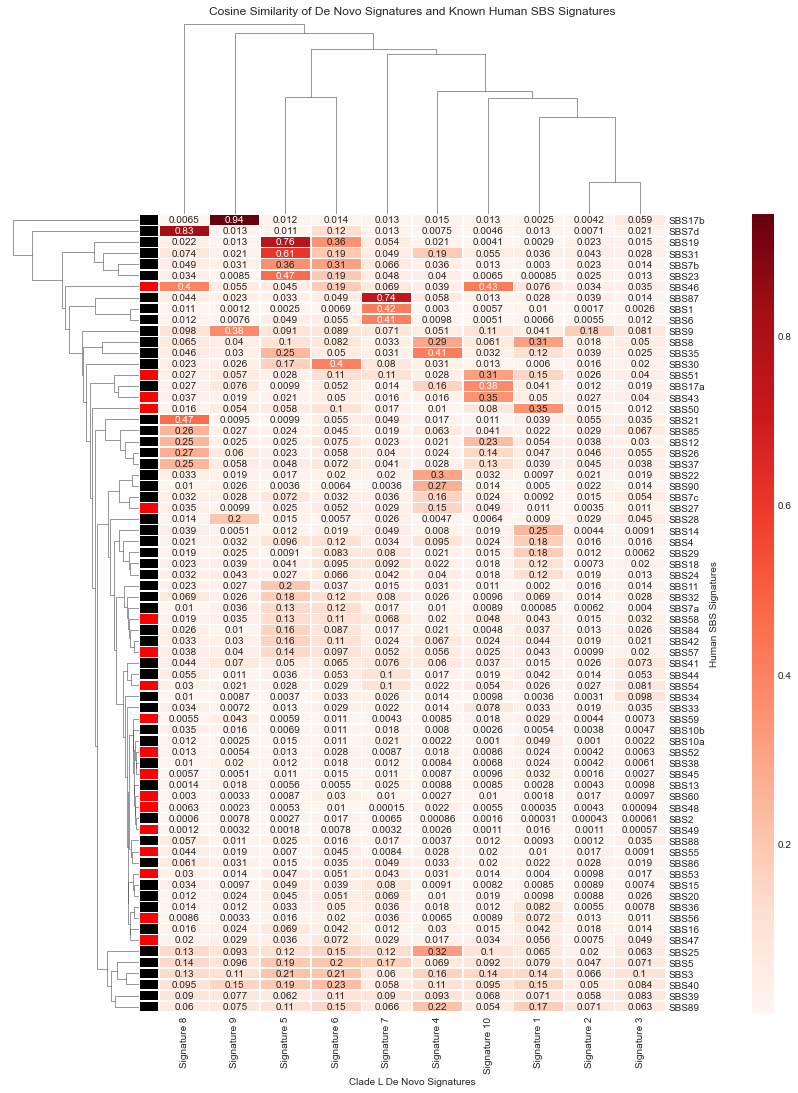

In [207]:
signature_comparison(clade= "L")

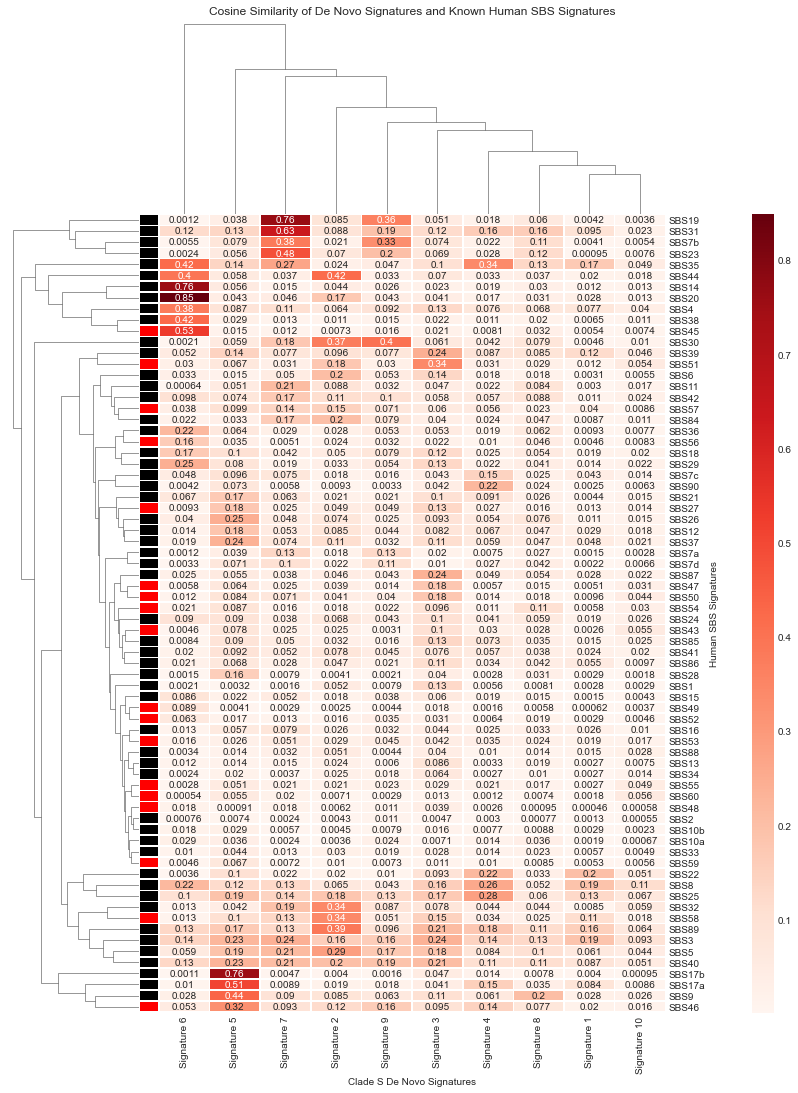

In [208]:
signature_comparison(clade= "S")

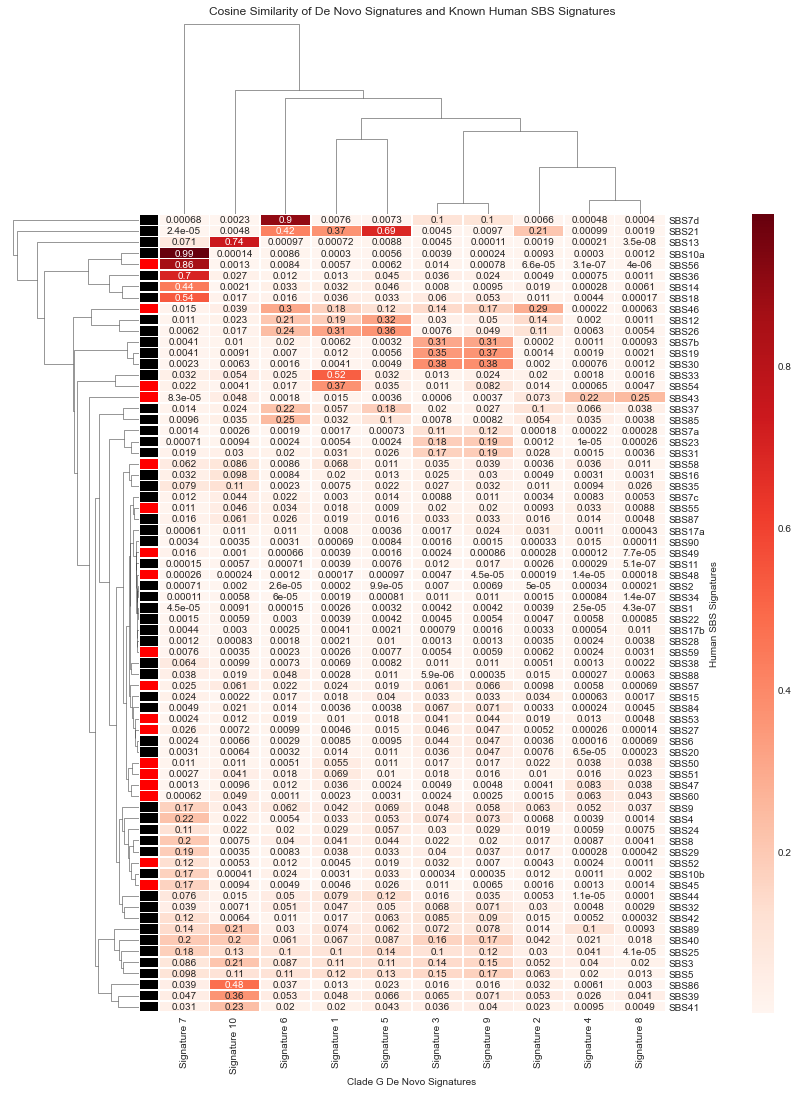

In [212]:
signature_comparison(clade= "G")

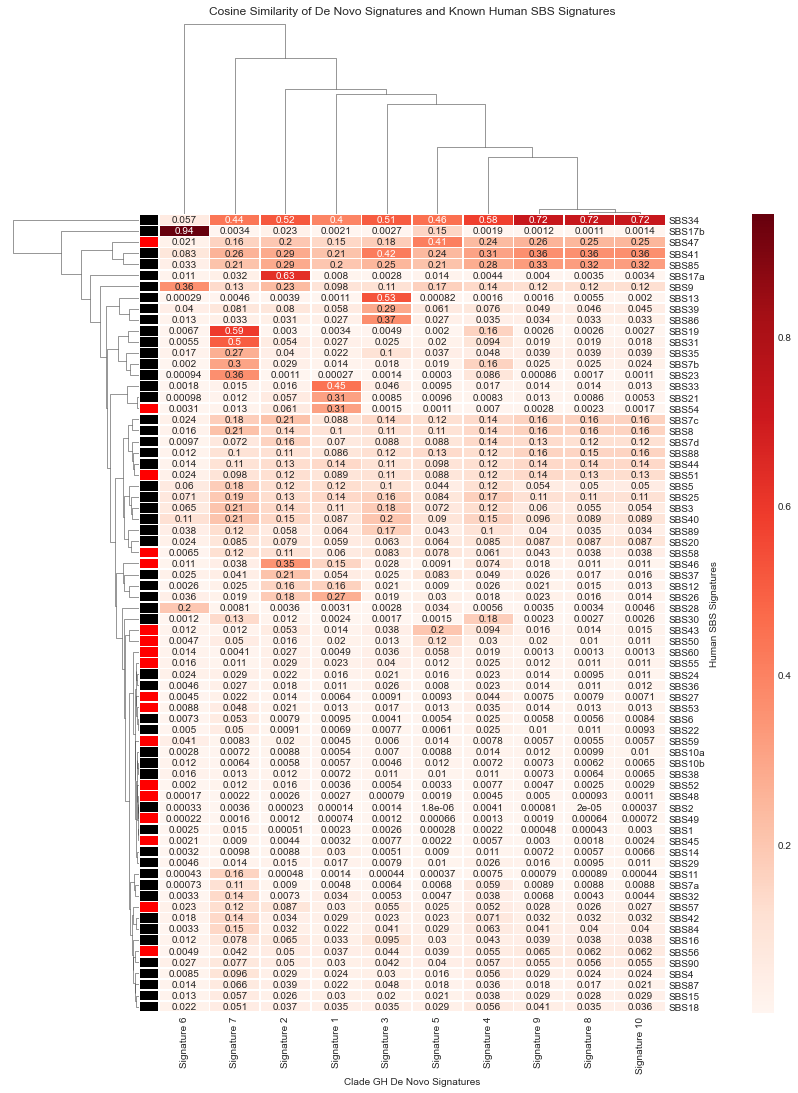

In [213]:
signature_comparison(clade= "GH")

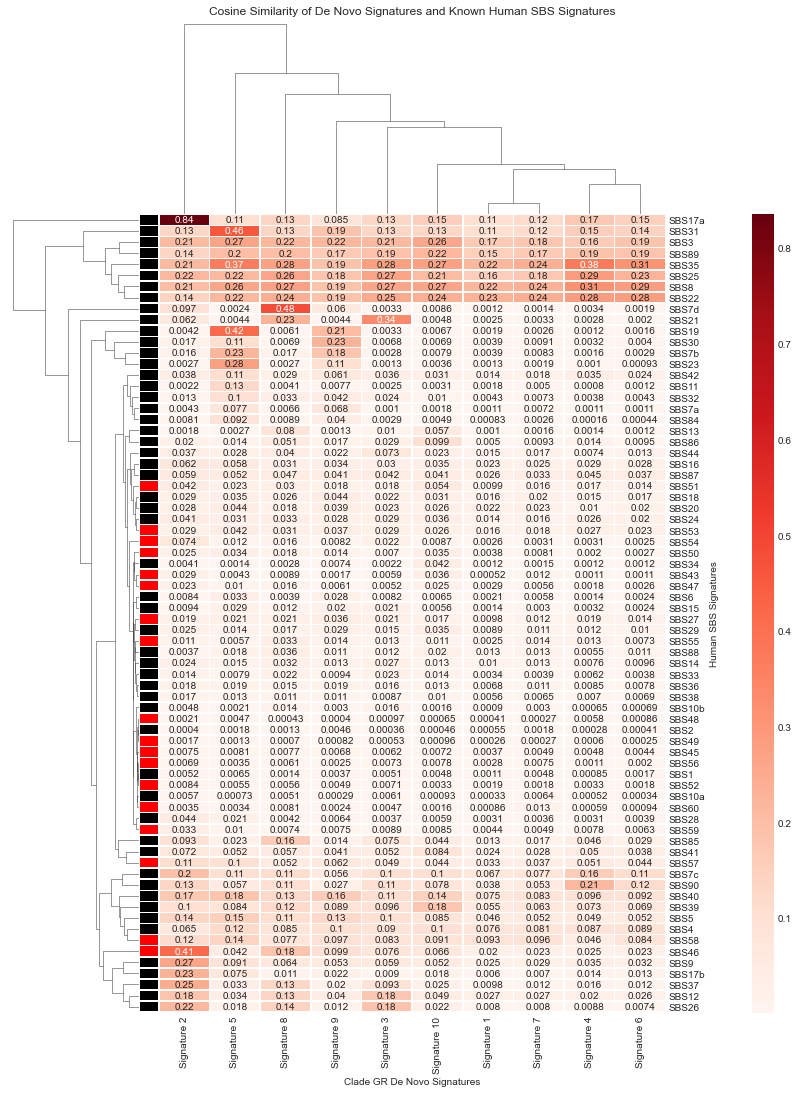

In [214]:
signature_comparison(clade= "GR")

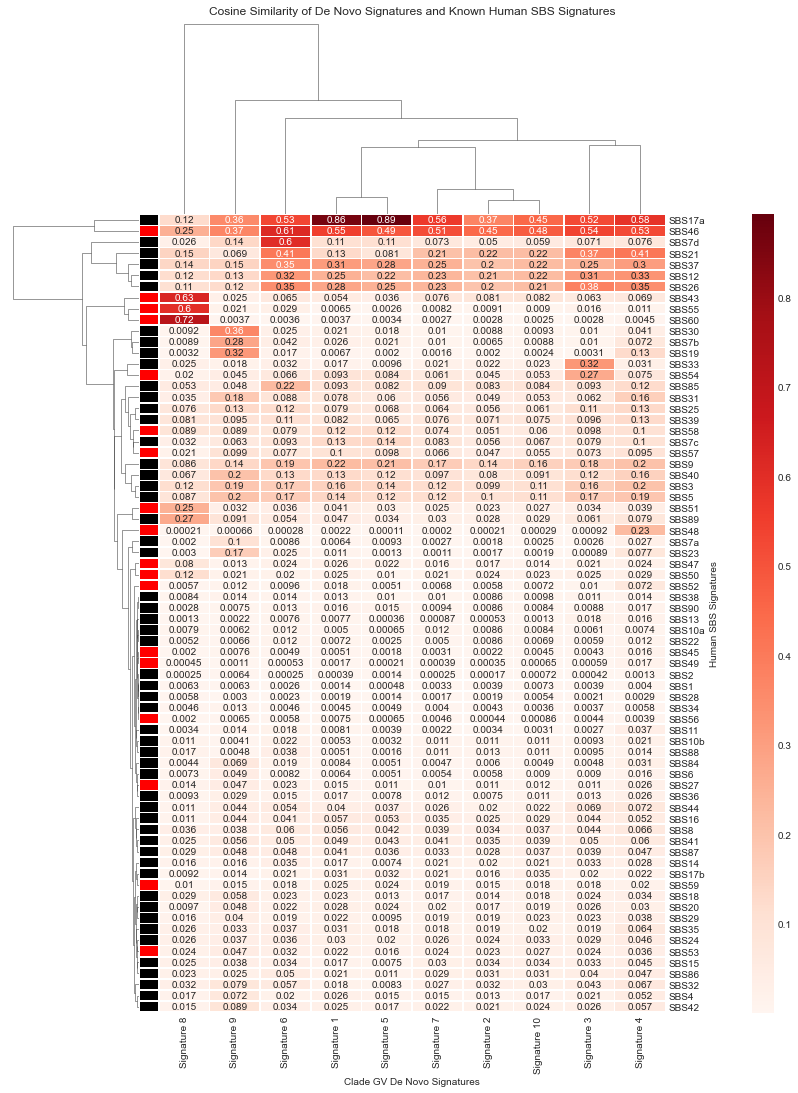

In [215]:
signature_comparison(clade= "GV")